In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.io import loadmat
import wfdb
from wfdb import processing
import os

# Error detection

In [2]:
def segment_peaks(nsub, nseg, start=0, end=5000):

    # ECG segment
    ecg_mat = loadmat(f"ECG_segments_data/ecg_segments/ecg_sub{nsub}_seg{nseg}.mat")
    ecg = pd.DataFrame({
        't': ecg_mat['t'].squeeze(),
        'signal': ecg_mat['ecg'].squeeze()
    })
    ecg = ecg.reset_index()
    ecg.rename(columns={'index': 'idt'}, inplace=True)
    
    # Annotations
    peaks = pd.read_csv(f'ECG_segments_data/manual_annotations/ecg_sub{nsub}_seg{nseg}_labels.csv', header=None)
    peaks = peaks.reset_index()
    peaks.rename(columns={'index':'id_label', 0: 'idt', 1: 'label_desc', 2: 'label'}, inplace=True)
    
    # BayeSlope
    bayeslope_mat = loadmat(f'ECG_segments_data/Rpeaks_BayeSlope_Pulp/Rpeaks_BayeSlope_sub{nsub}_seg{nseg}.mat')
    bayeslope_array = bayeslope_mat['R_bs_cut']-1 # there is an error in the indexing
    bayeslope = pd.DataFrame(bayeslope_array)
    bayeslope = bayeslope.reset_index()
    bayeslope.rename(columns={'index':'id_BayeSlope', 0: 'idt'}, inplace=True)
    bayeslope['BayeSlope']='R'
    
    # Merges
    ECG = ecg.merge(bayeslope, how='left', on='idt')\
        .merge(peaks[['id_label', 'idt', 'label']], how='left', on='idt')
    return ECG[(ECG['idt']>=start) & (ECG['idt']<=end)]

In [3]:
def comparitor_segment(nsub, nseg):

    # ECG
    ECG = segment_peaks(nsub, nseg)
    peaks_annotations = ECG[ECG['label']=='R']
    peaks_bayeslope = ECG[ECG['BayeSlope']=='R']

    # Comparitor
    ref_sample = peaks_annotations['idt'].to_numpy()
    test_sample = peaks_bayeslope['idt'].to_numpy()
    fs = 250
    t_tol = 0.050 # 50ms
    window_width = int(t_tol*fs)
    signal = ECG['signal'].to_numpy()
    
    comparitor = processing.compare_annotations(ref_sample, test_sample, window_width, signal)

    # Errors
    FP = comparitor.unmatched_test_sample
    FN = comparitor.unmatched_ref_sample
    if len(FP)!=0:
        print(f'Falsely predicted peaks (subj{nsub}, segm{nseg}): ', FP)
    if len(FN)!=0:
        print(f'Not predicted peaks (subj{nsub}, segm{nseg}): ', FN)
    
    # Plot
    if len(FP)!=0 or len(FN)!=0:
        comparitor.plot(figsize=(20, 5), title=f'subject {nsub}, segment {nseg}')

    if len(FP)!=0:
        return (nsub, nseg)
    else:
        return 'NaN'

Falsely predicted peaks (subj2, segm1):  [1630 1822 1881 1963 2043 2801 4269 4329]
Not predicted peaks (subj2, segm1):  [1594 1675 1838 1920 2003 2084 2816 4288 4371]
Falsely predicted peaks (subj2, segm3):  [1621 2114 2185 2283 2352 2417 2504 2570 2644 2715 2780 2847 2931 3008
 3086 3159 3235 3312 3379 3444 3536 3622 3686 3753 3825 3909 3981 4059
 4274 4349 4418 4501 4579 4652 4725 4801 4876 4947]
Not predicted peaks (subj2, segm3):  [1636 2084 2148 2233 2299 2365 2456 2531 2605 2680 2754 2829 2903 2979
 3053 3127 3202 3277 3351 3426 3500 3574 3650 3723 3799 3873 3947 4022
 4096 4245 4319 4394 4469 4542 4618 4692 4765 4840 4914 4988]
Falsely predicted peaks (subj2, segm4):  [  43  122  190  269  348 1307 1378 1452 1525 1598 1672 1747 1820 1896
 1966 2112 2186 2262 2335 2410 2484 2557 2630 2701 2778 2850 2921 2999
 3075 3140 3219 3295 3368 3443 3515 3589 3661 3740 3814 3887 3955 4035
 4112 4185 4260 4338 4411 4486 4558 4635 4706 4782 4858 4932]
Not predicted peaks (subj2, segm4):  [  1

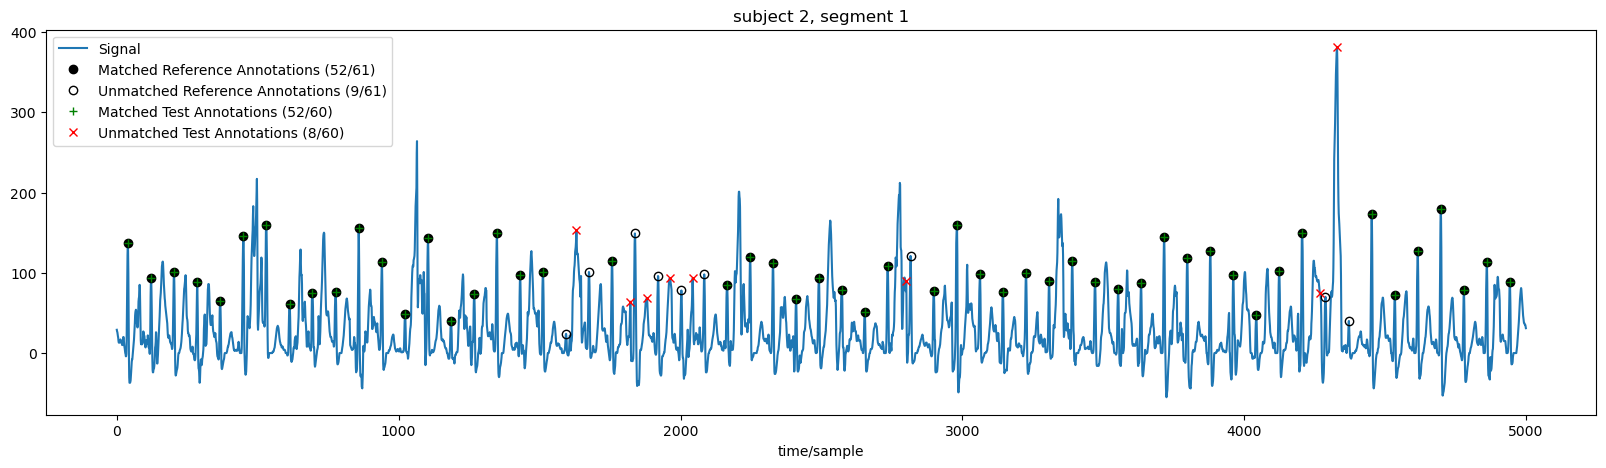

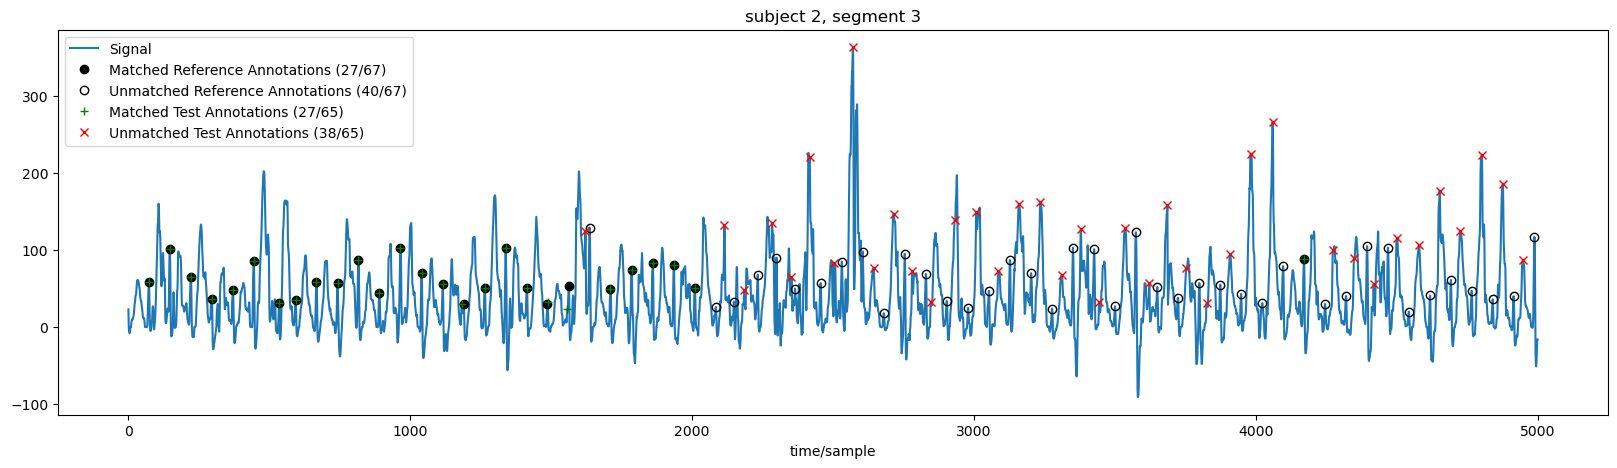

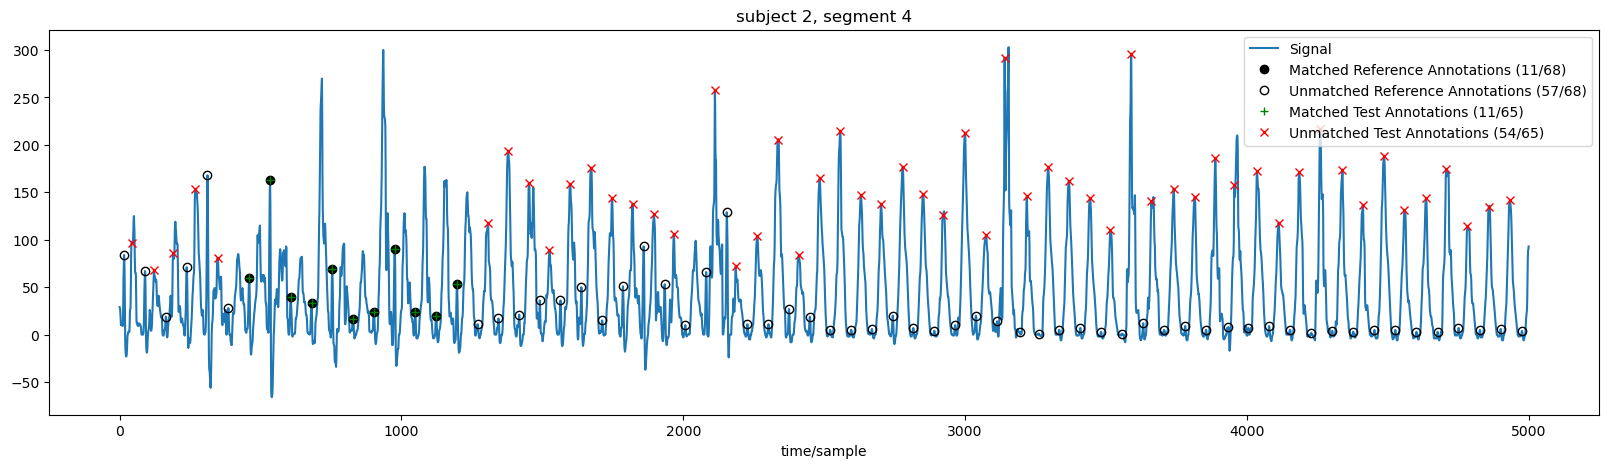

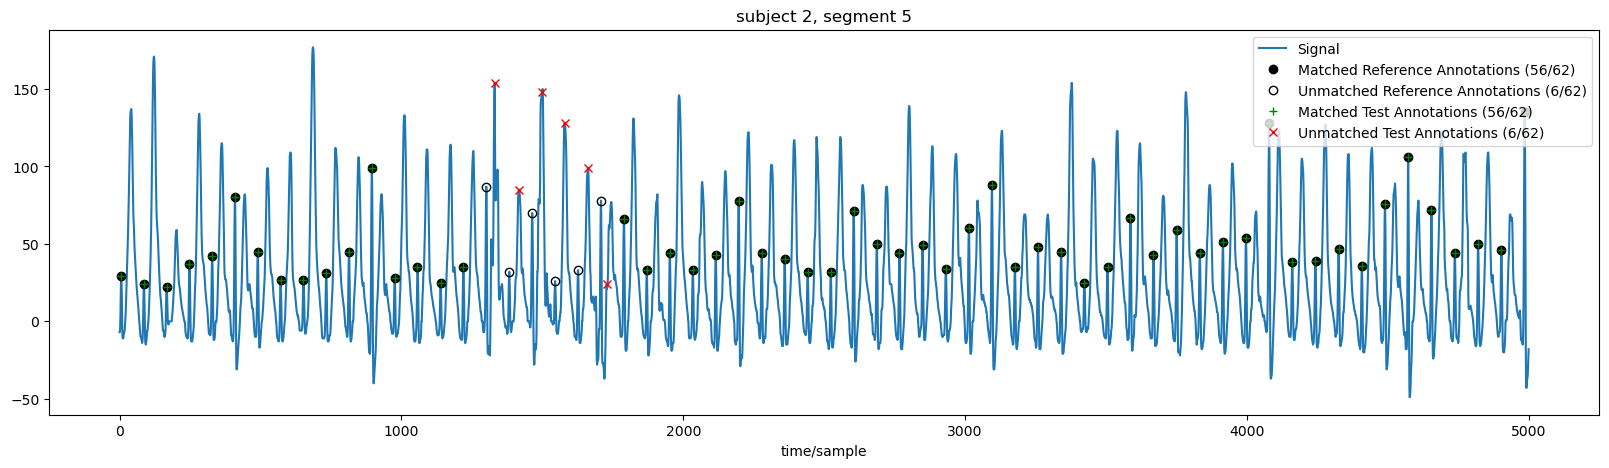

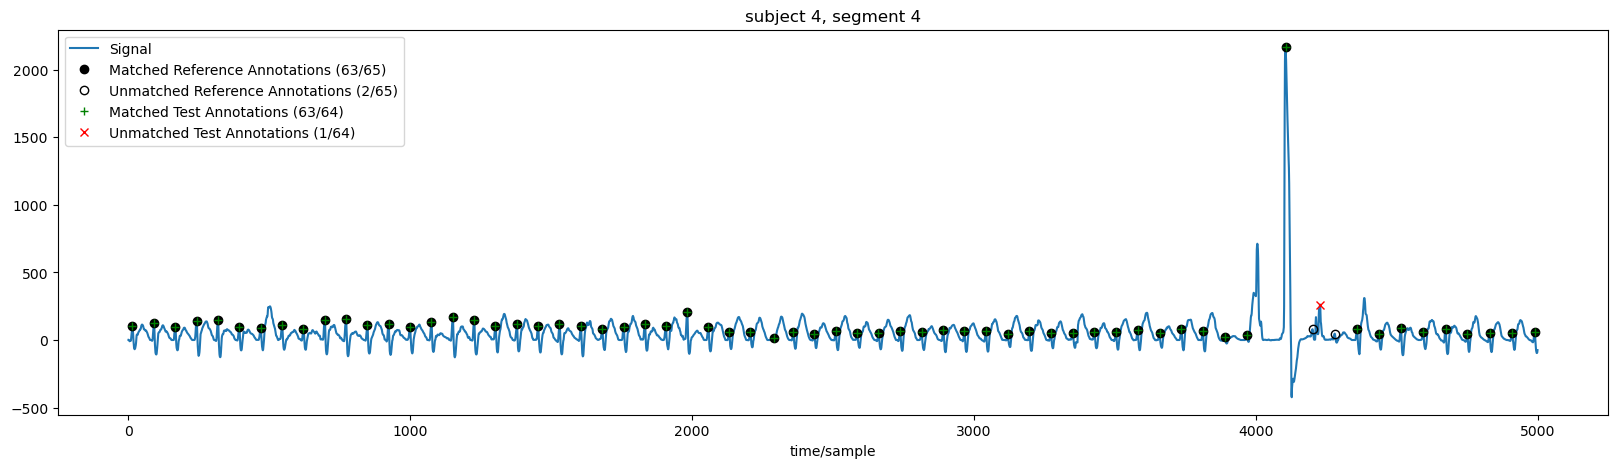

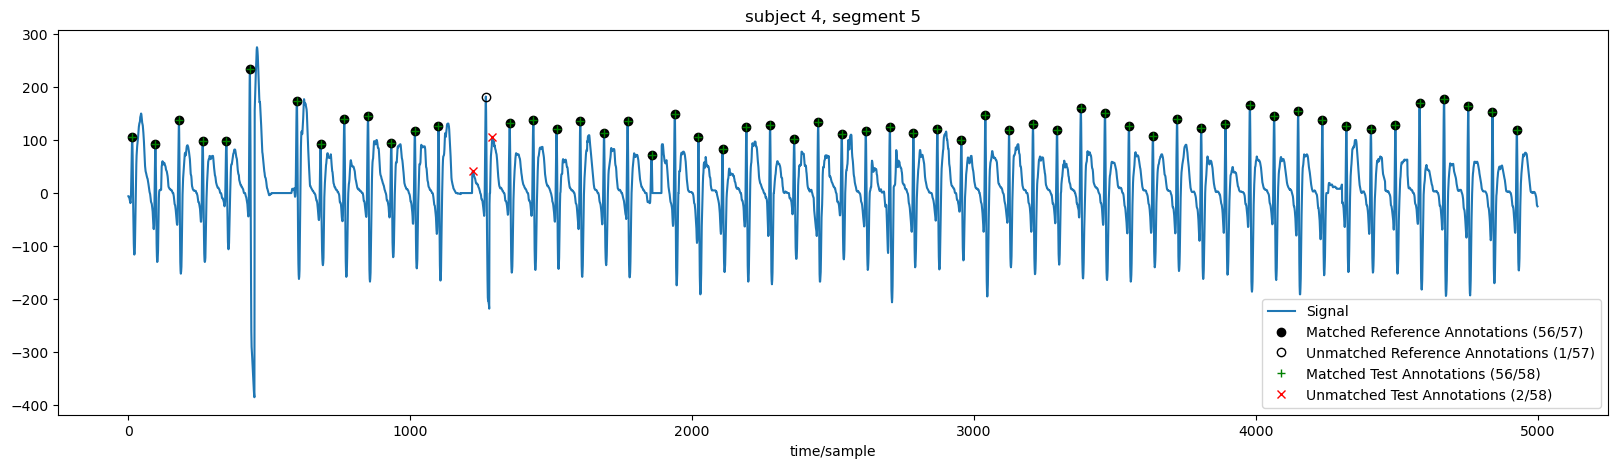

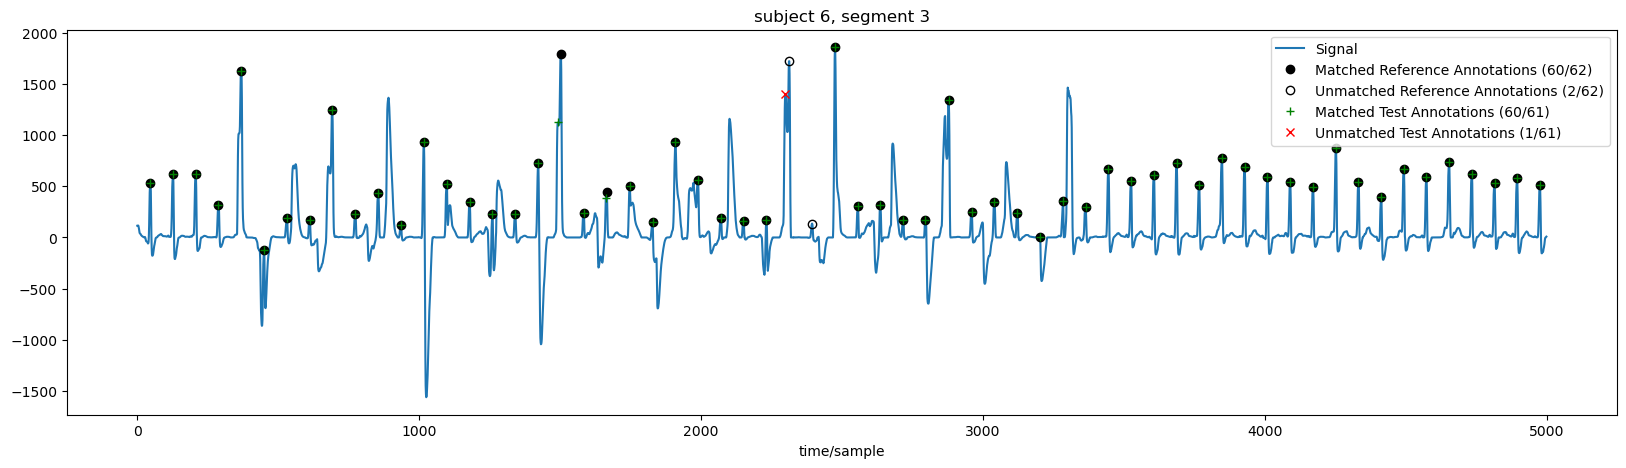

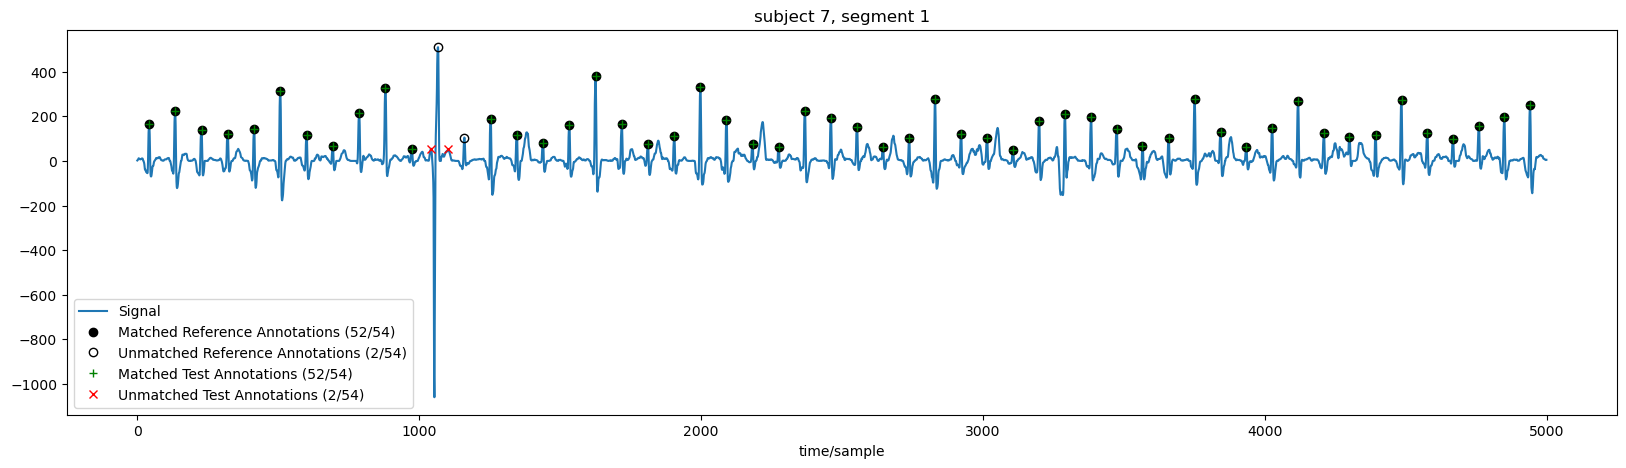

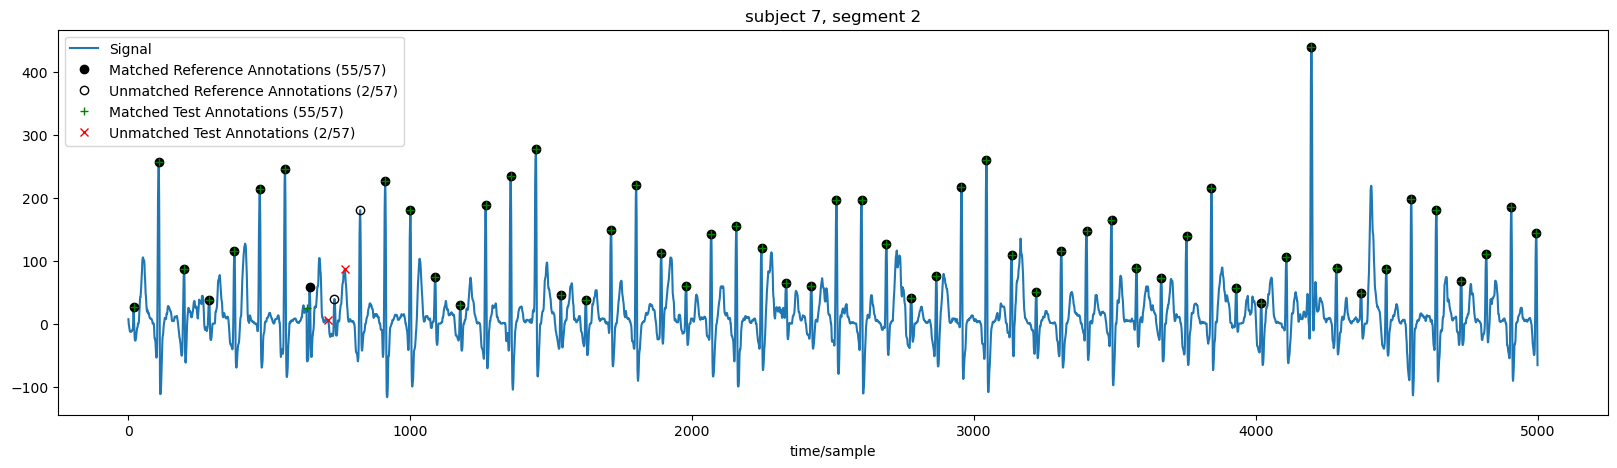

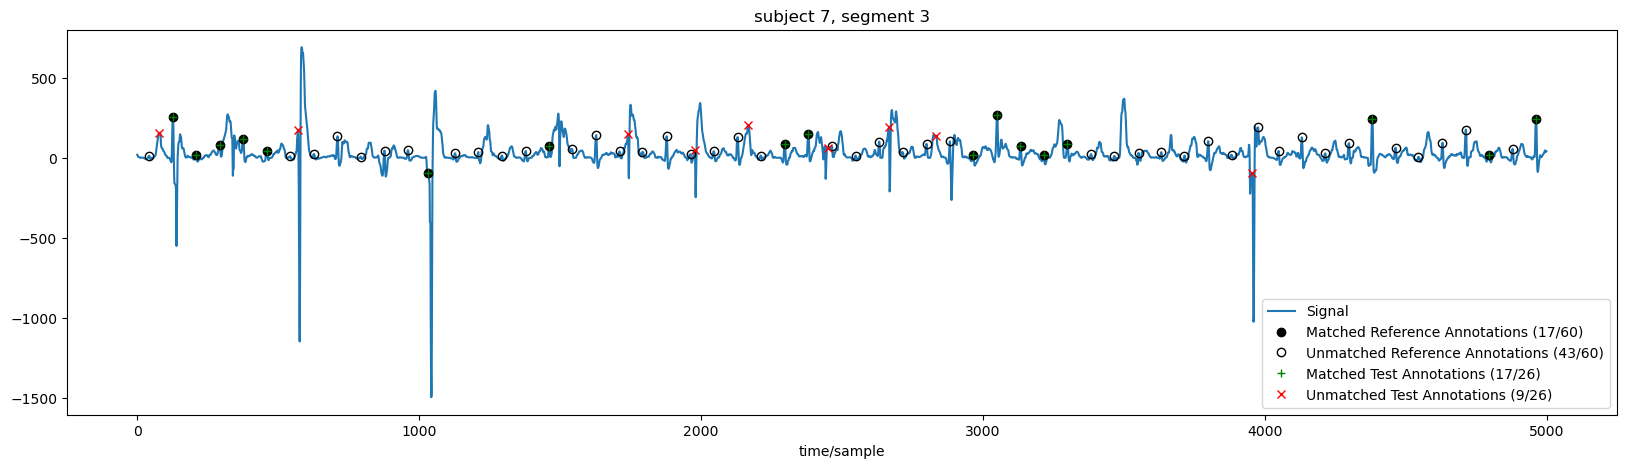

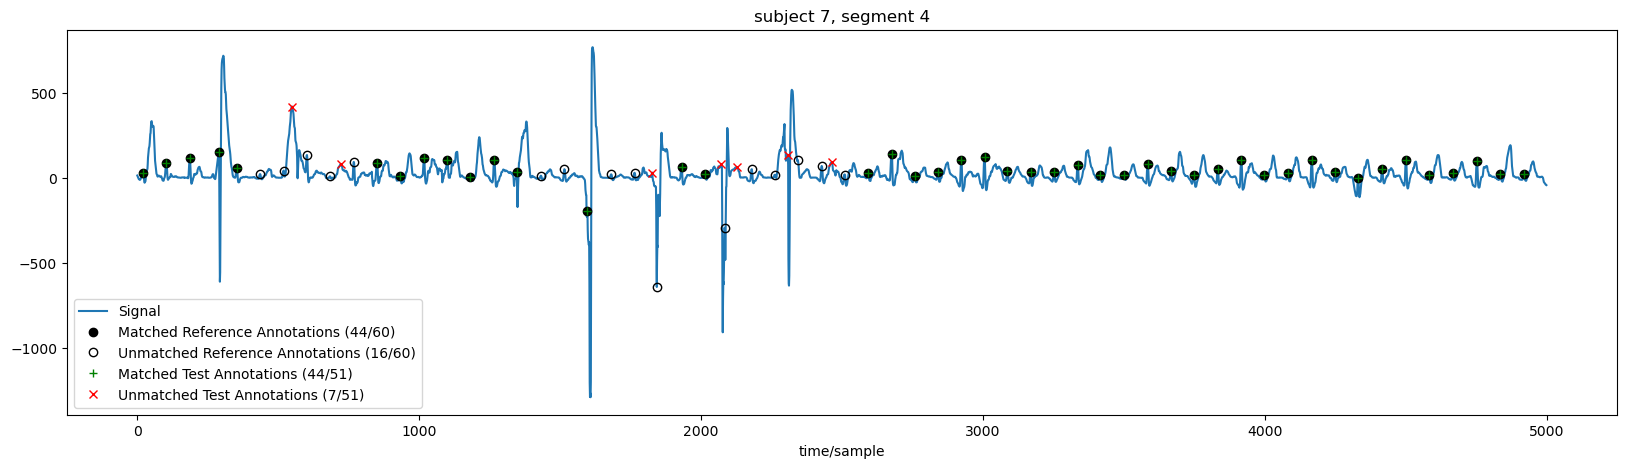

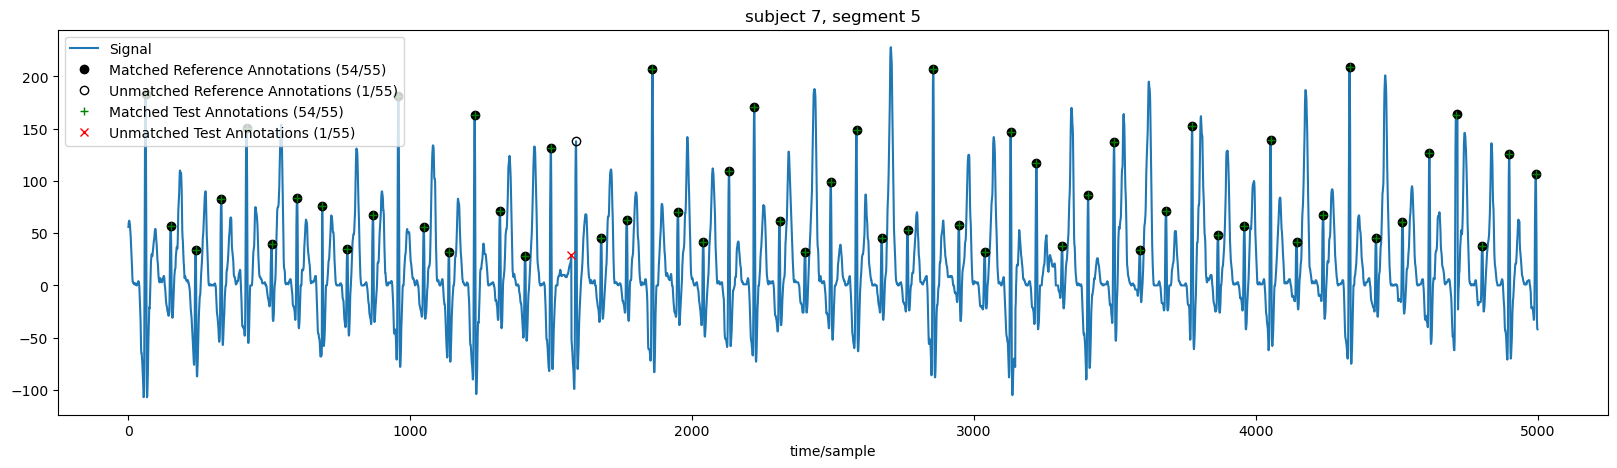

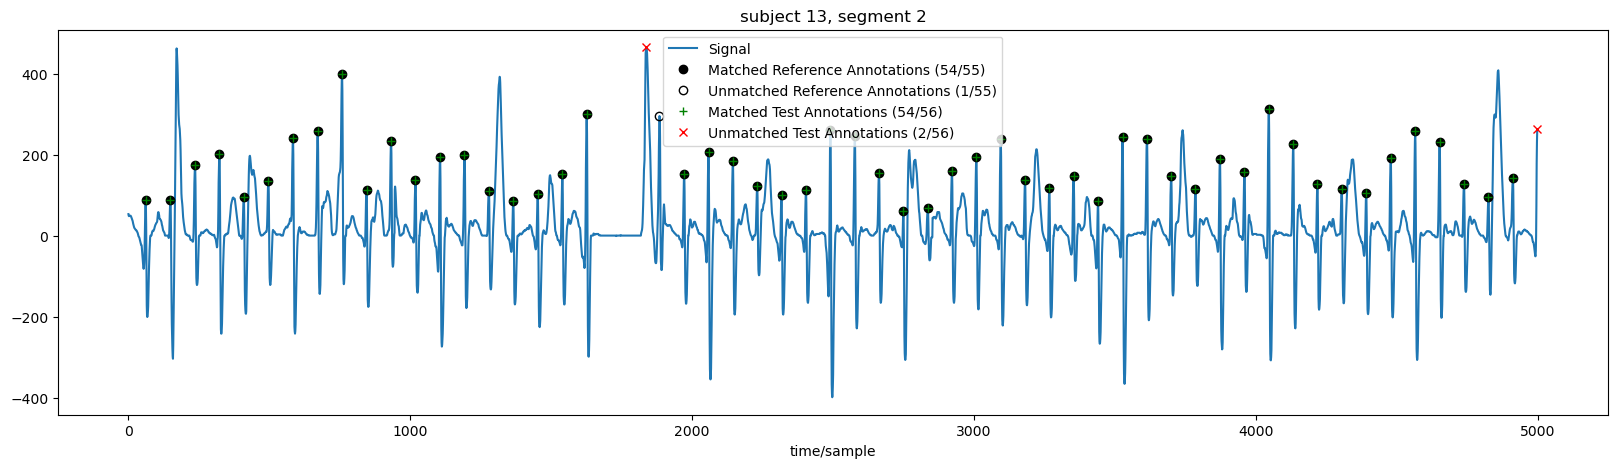

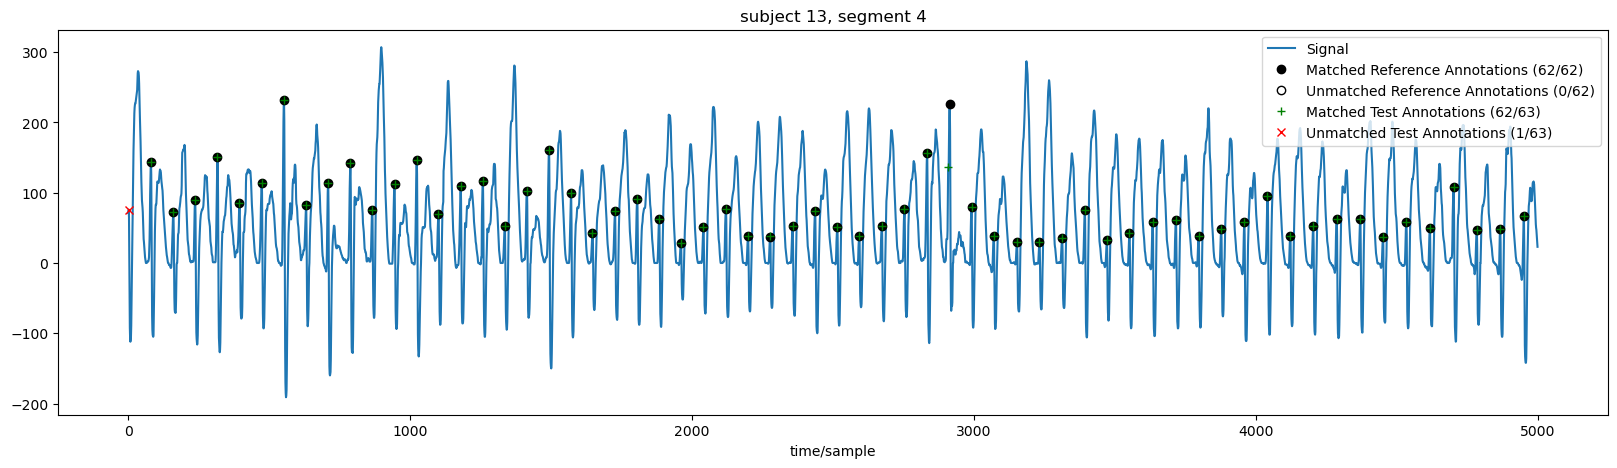

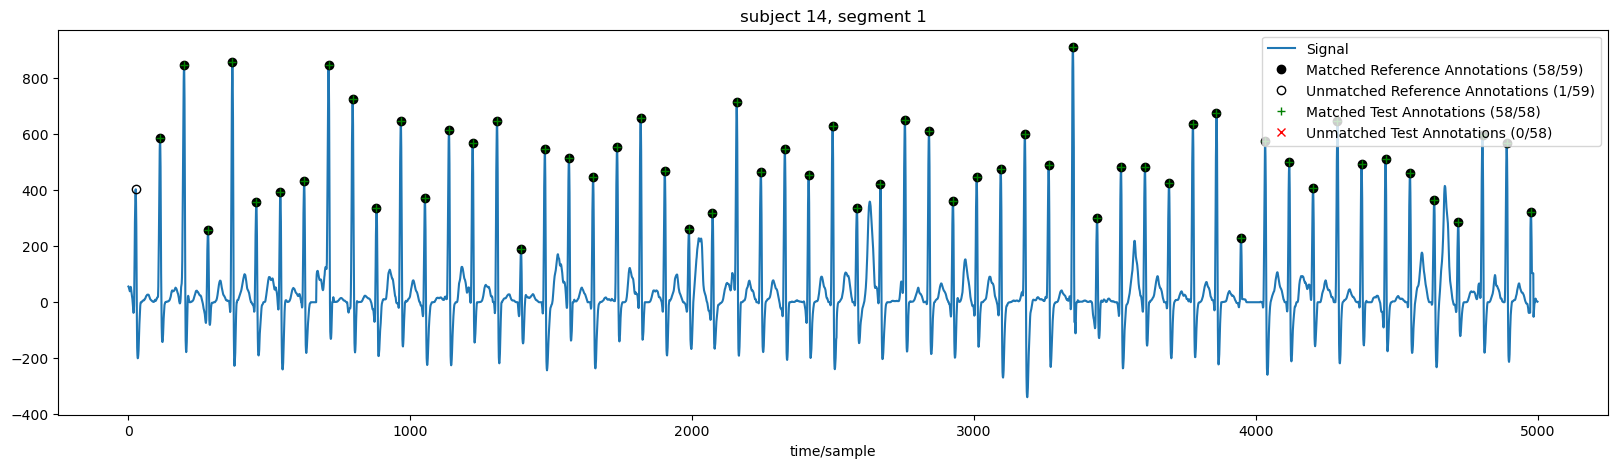

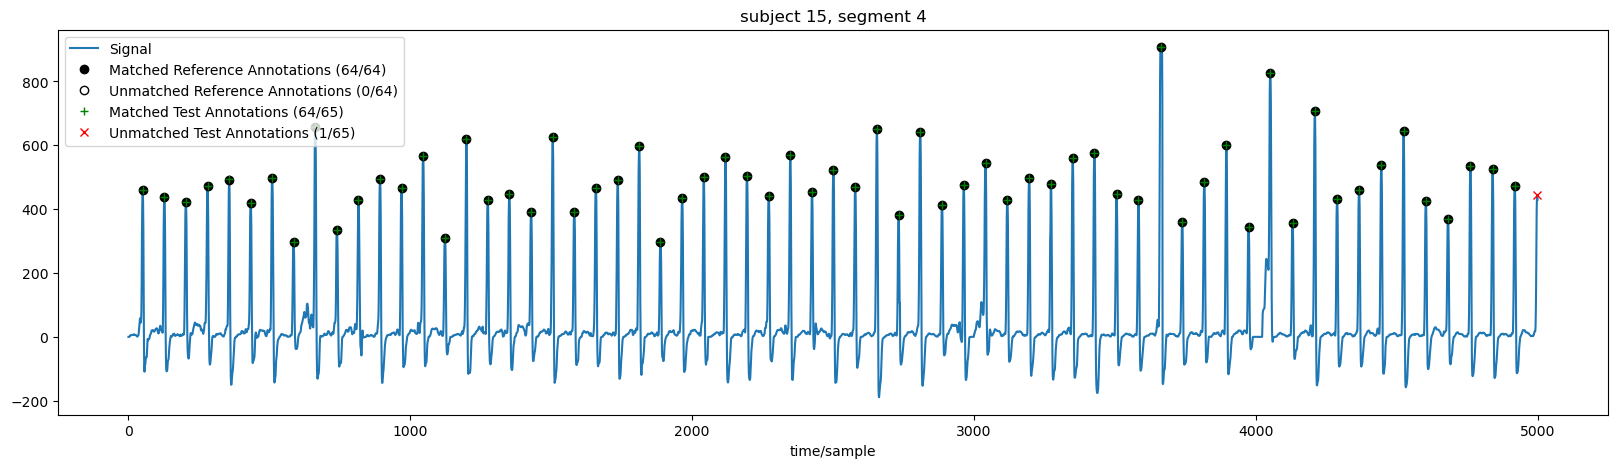

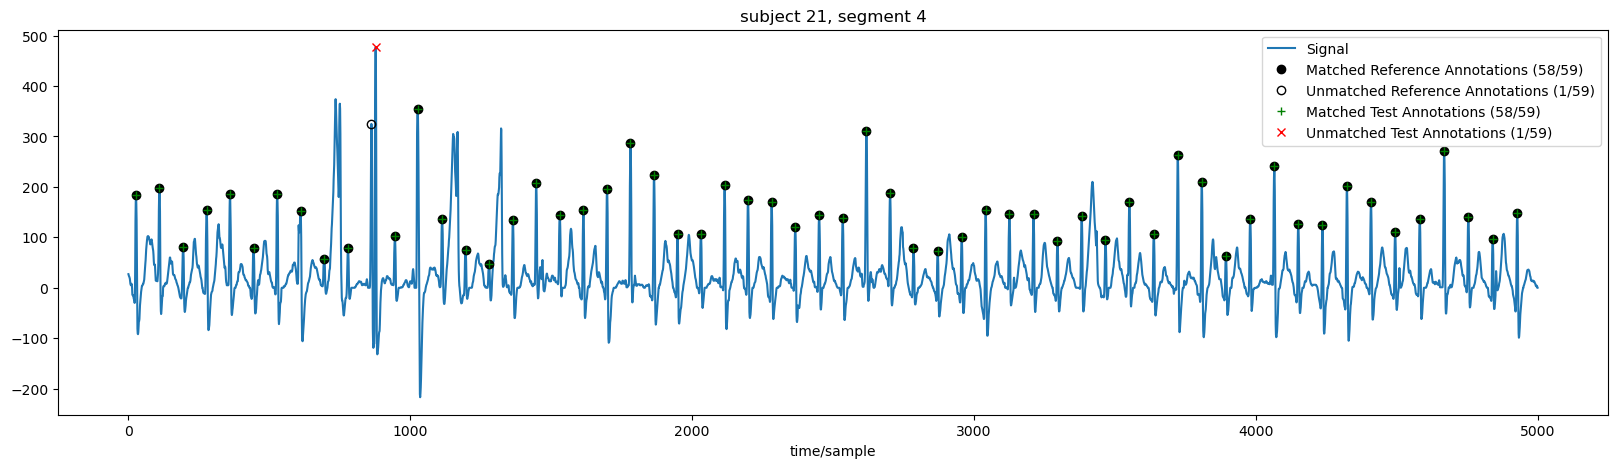

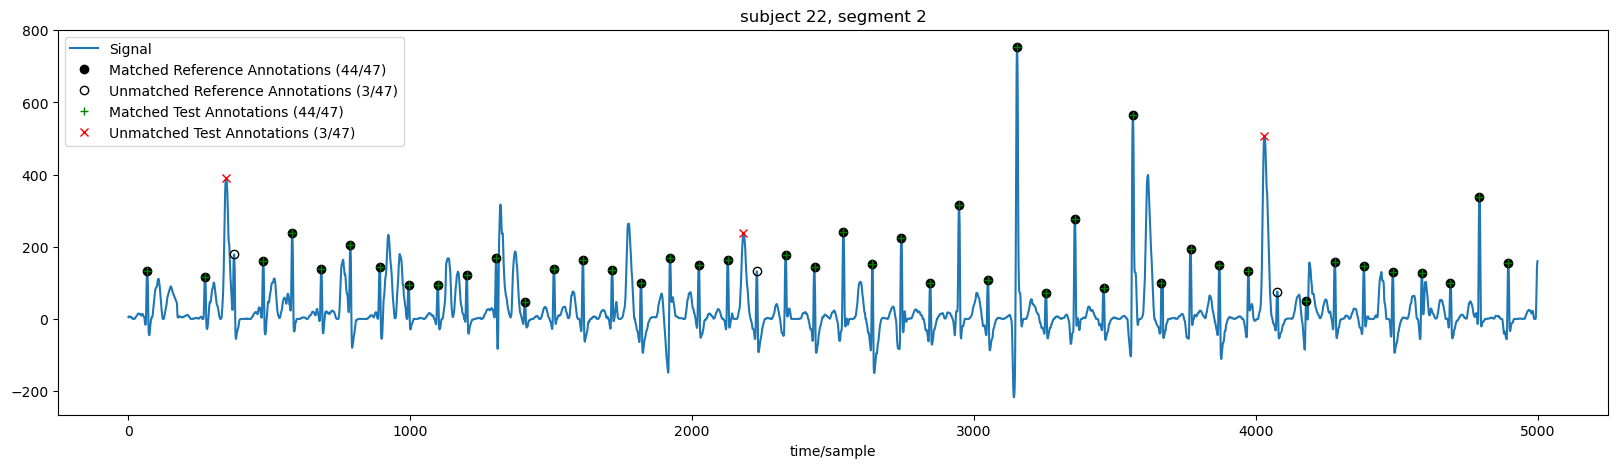

In [4]:
errors_list=[]
for i in range(1, 23):
    for j in range(1, 6):
        if i==5 or (i, j)==(9, 5) or i==12:
            pass
        else:
            errors_list.append(comparitor_segment(i, j))

In [5]:
errors_list = [x for x in errors_list if x != 'NaN']
print(errors_list)

[(2, 1), (2, 3), (2, 4), (2, 5), (4, 4), (4, 5), (6, 3), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (13, 2), (13, 4), (15, 4), (21, 4), (22, 2)]


# Error classification

In [6]:
def plot_segment_part(nsub, nseg, npart, start, end):

    # ECG
    ECG = segment_peaks(nsub, nseg, start, end)
    peaks_annotations = ECG[ECG['label']=='R']
    peaks_bayeslope = ECG[ECG['BayeSlope']=='R']
    
    # plot
    plt.figure(figsize=(15, 7))
    
    plt.plot(ECG['t'], ECG['signal'], label='ECG')
    plt.scatter(peaks_annotations['t'], peaks_annotations['signal'], marker='o', facecolor='none', color='k', label='R peaks annotations')
    for _, row in peaks_annotations.iterrows():
        plt.text(row['t'], row['signal']+10, str(int(row['id_label'])+1), fontsize=8, color='black')
    plt.scatter(peaks_bayeslope['t'], peaks_bayeslope['signal'], marker='.', color='r', label='R peaks BayeSlope')
    plt.legend(loc='upper left')
    plt.title(f'subject {nsub}, segment {nseg}, errors {npart}')
    plt.xlabel("Time (s)")
    plt.show()

In [7]:
columns = ['subject', 'segment', 'error_id', 'start', 'end']

data = [
    [2, 1, 1, 1300, 2500],
    [2, 1, 2, 2600, 3000],
    [2, 1, 3, 4000, 4500],
    [2, 3, 1, 1300, 1900],
    [2, 3, 2, 1900, 3500],
    [2, 3, 3, 3500, 5000],
    [2, 4, 1, 0, 600],
    [2, 4, 2, 1000, 5000],
    [2, 5, 1, 1000, 2000],
    [4, 4, 1, 4000, 4500],
    [4, 5, 1, 1000, 1500],
    [6, 3, 1, 2000, 2600],
    [7, 1, 1, 800, 1300],
    [7, 2, 1, 400, 1100],
    [7, 3, 1, 0, 800],
    [7, 3, 2, 500, 1200],
    [7, 3, 3, 900, 1600],
    [7, 3, 4, 1200, 2700],
    [7, 3, 5, 2200, 3200],
    [7, 3, 6, 3100, 5000],
    [7, 5, 1, 1200, 1900],
    [13, 2, 1, 1500, 2100],
    [13, 2, 2, 4700, 5000],#extreme peak: not error, no annotation due to lack info
    [13, 4, 1, 0, 300],
    [14, 1, 1, 0, 300],
    [15, 4, 1, 4700, 5000],#extreme peak: not error, no annotation due to lack info
    [21, 4, 1, 400, 1200],
    [22, 2, 1, 0, 700],
    [22, 2, 2, 1800, 2500],
    [22, 2, 3, 3700, 4500]
]

Errors = pd.DataFrame(data, columns=columns)

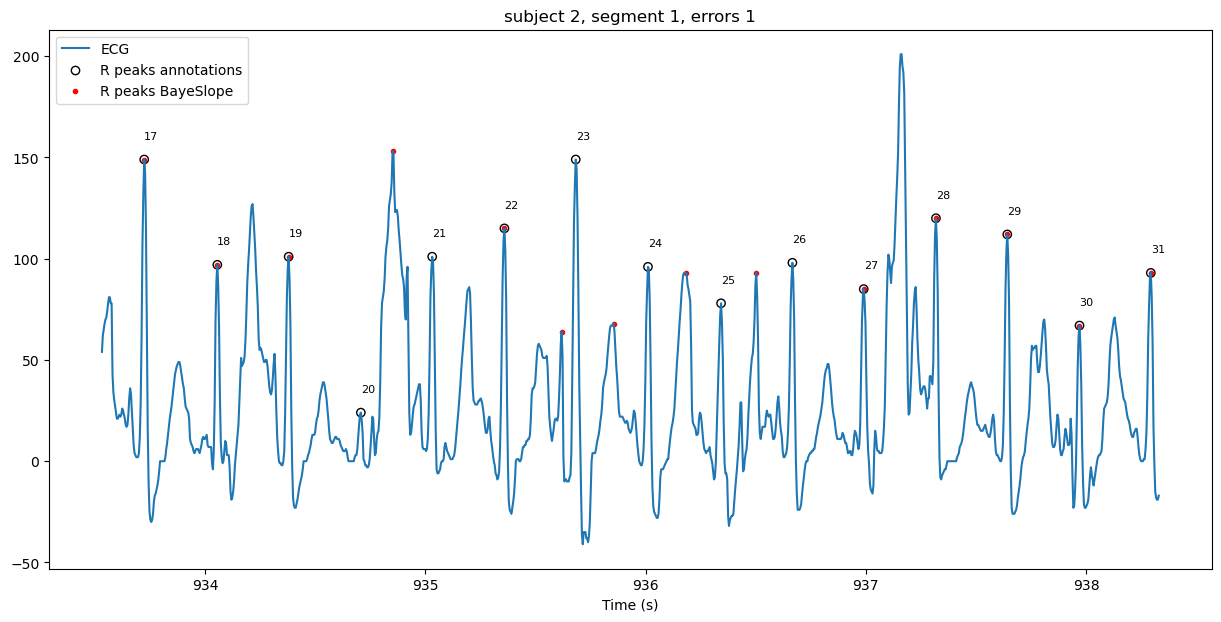

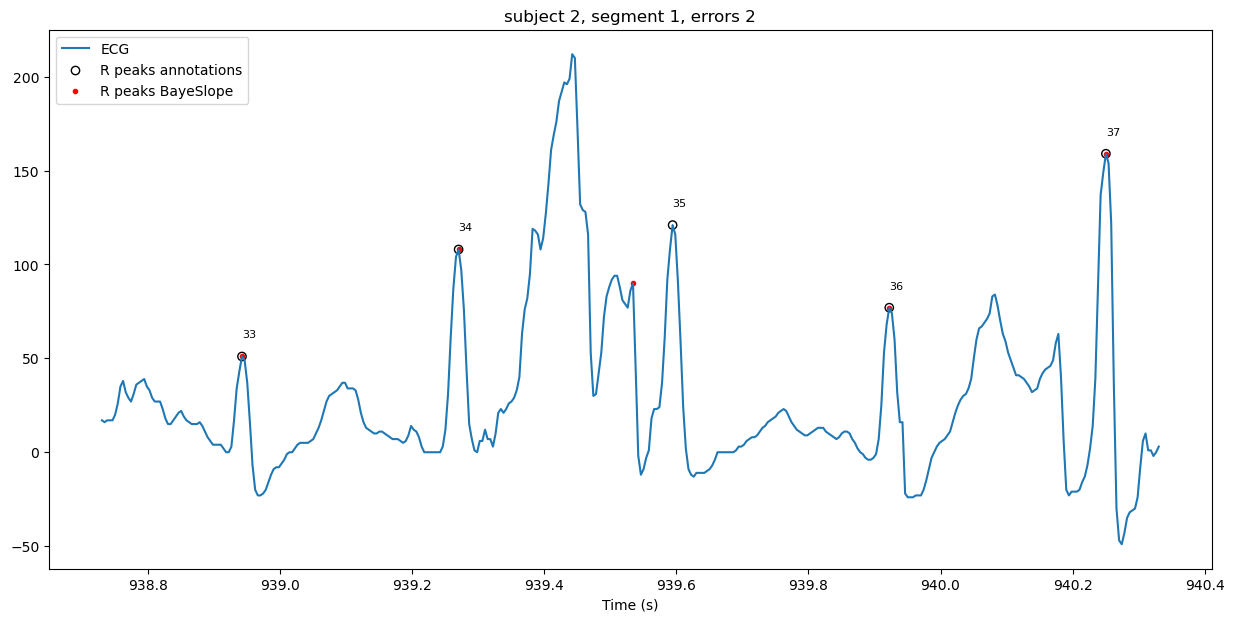

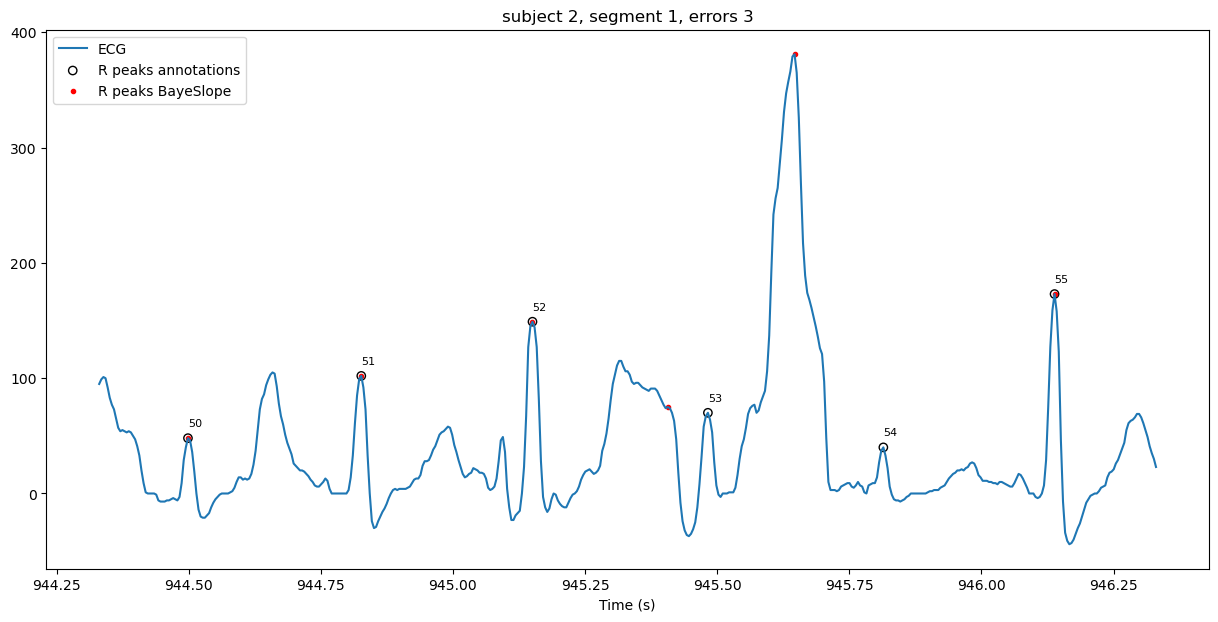

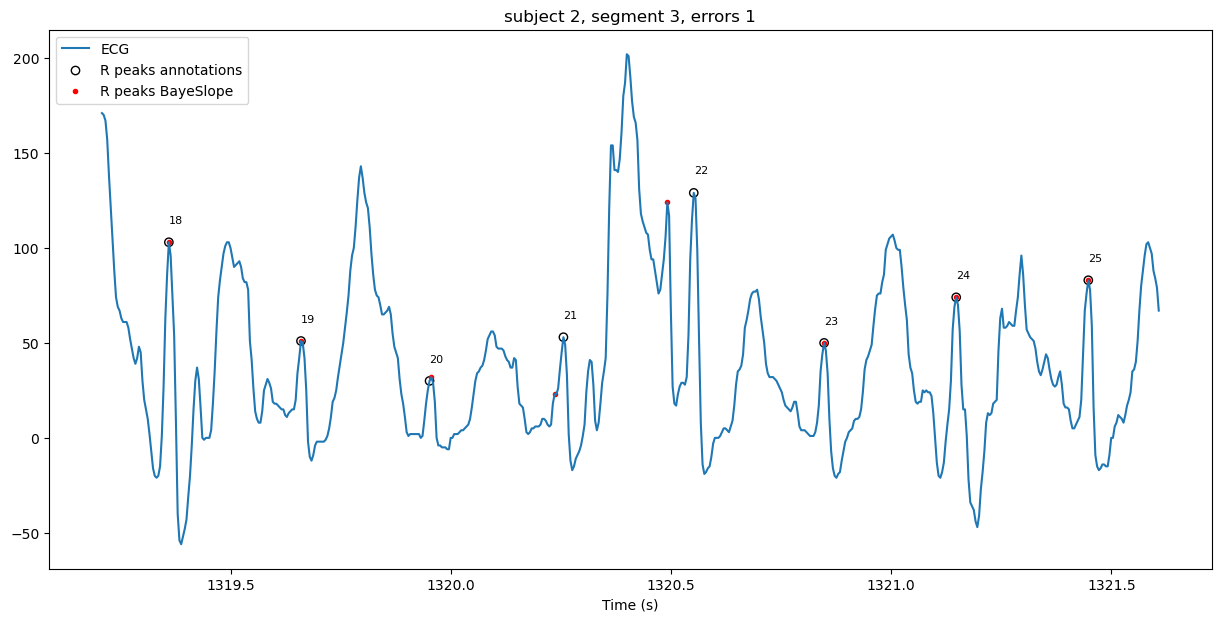

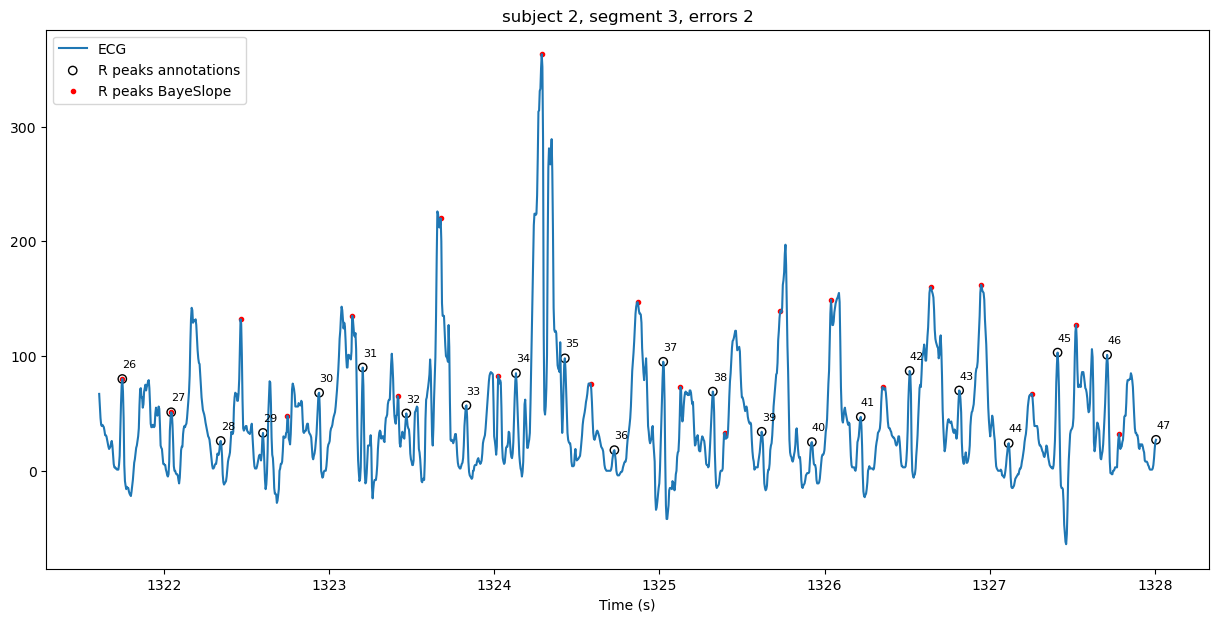

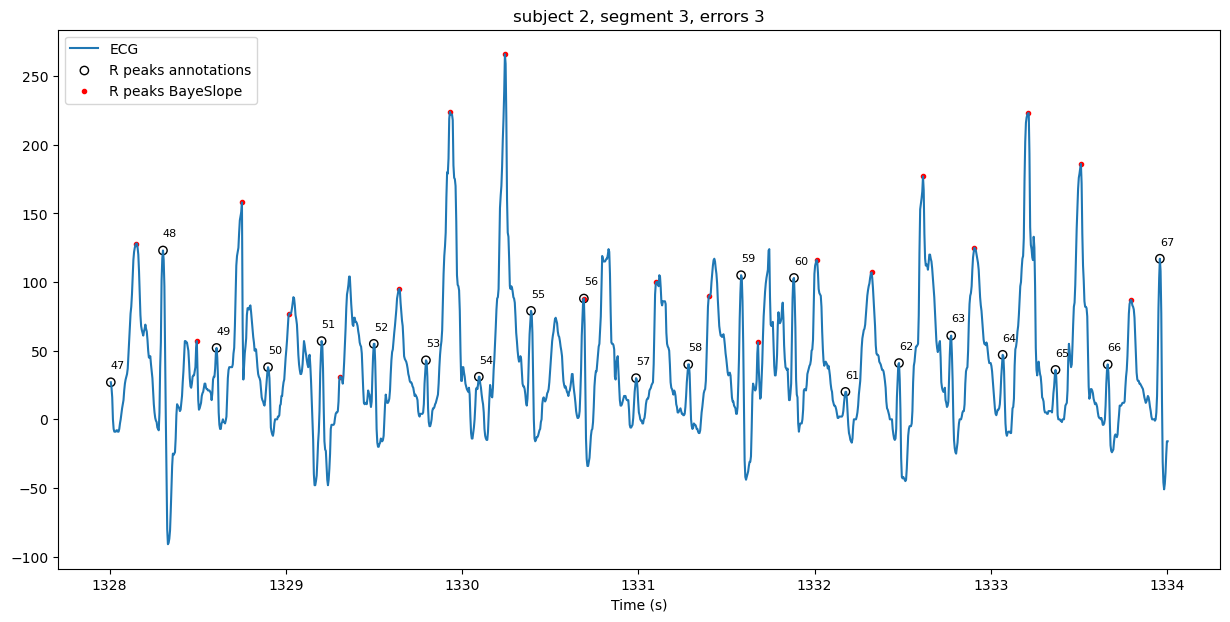

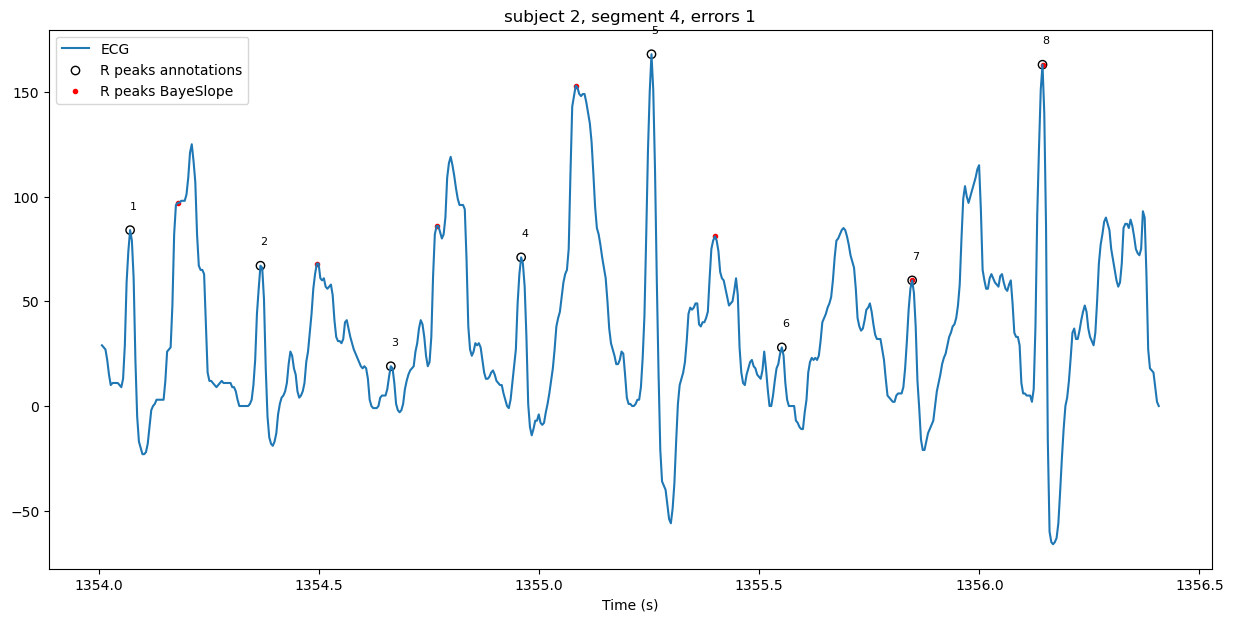

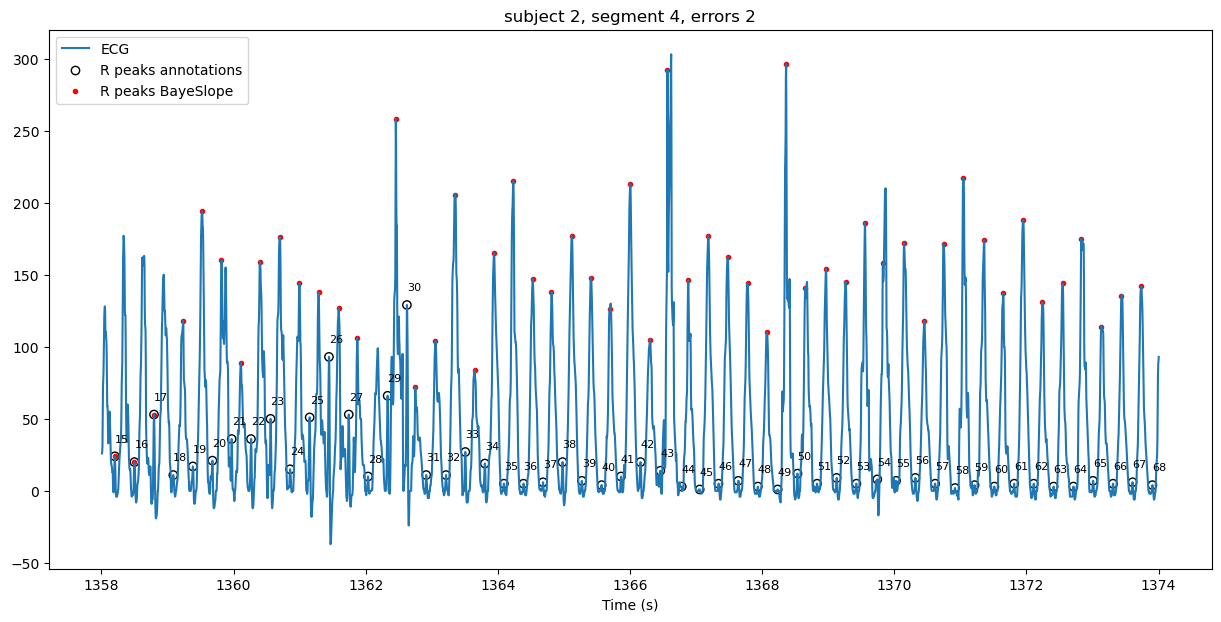

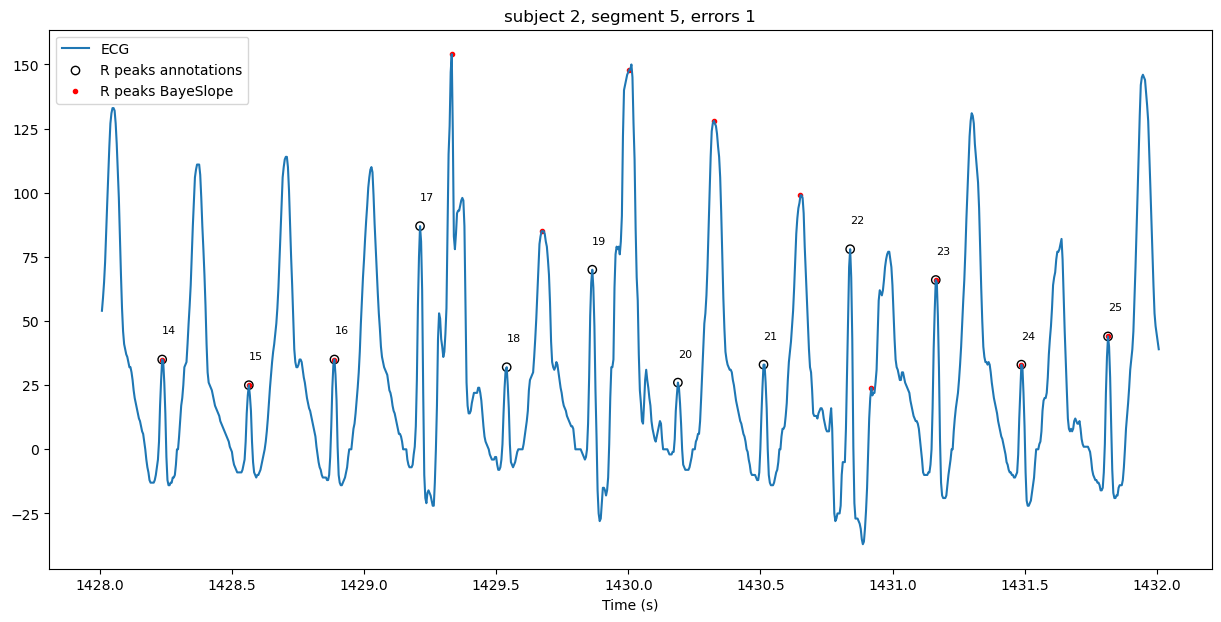

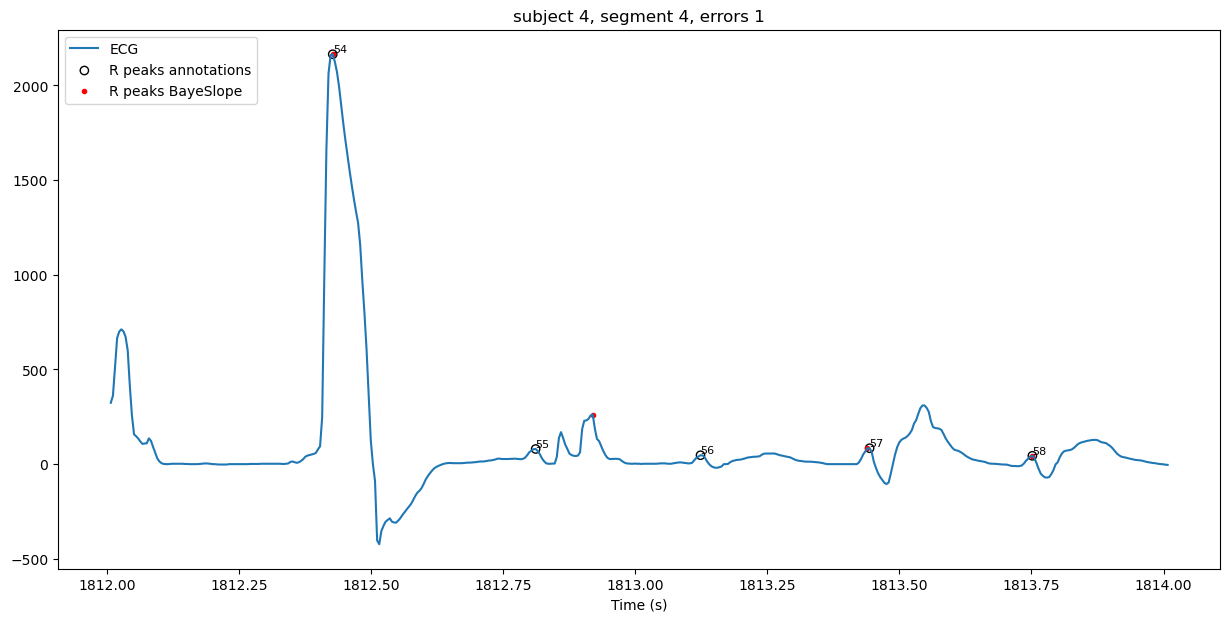

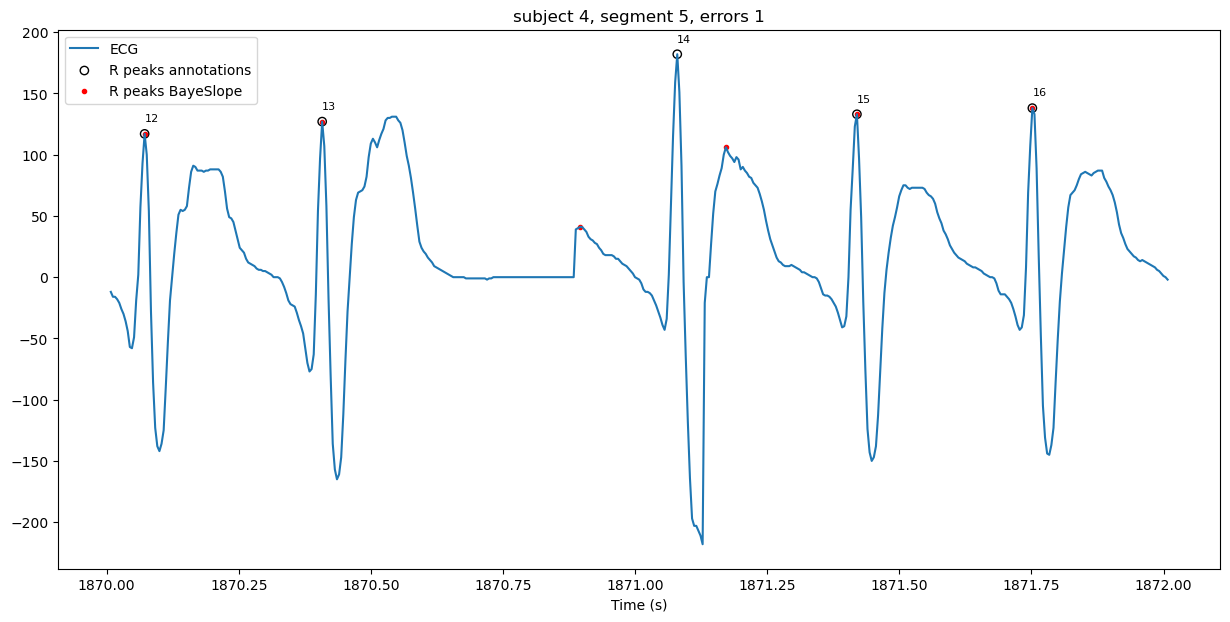

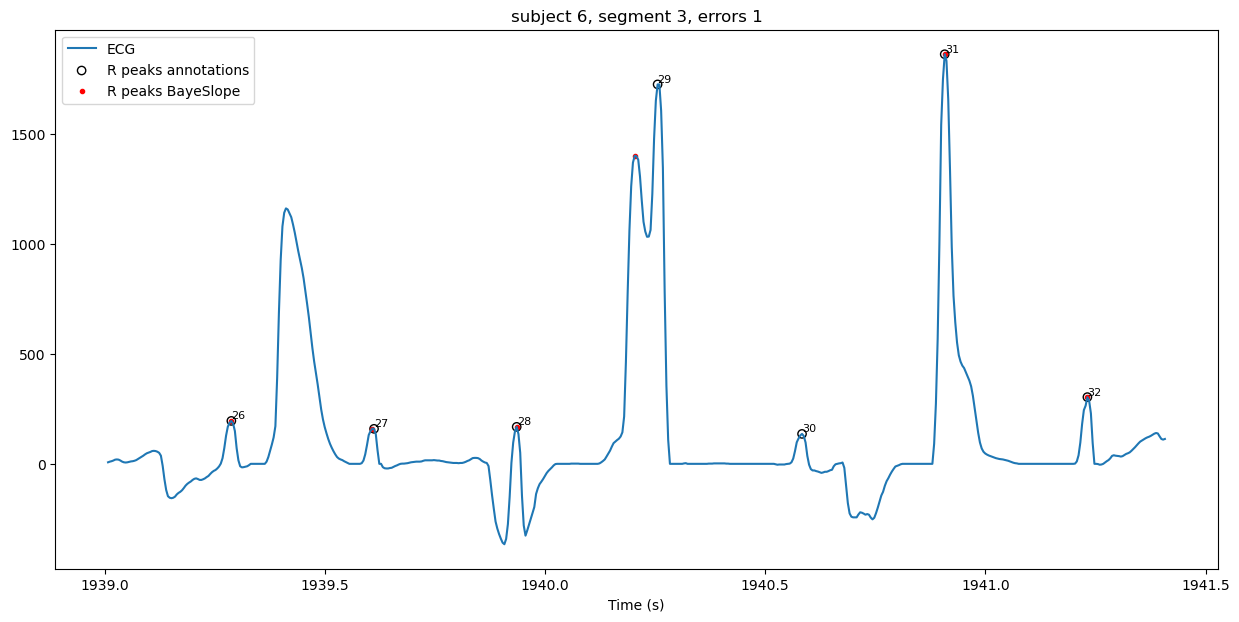

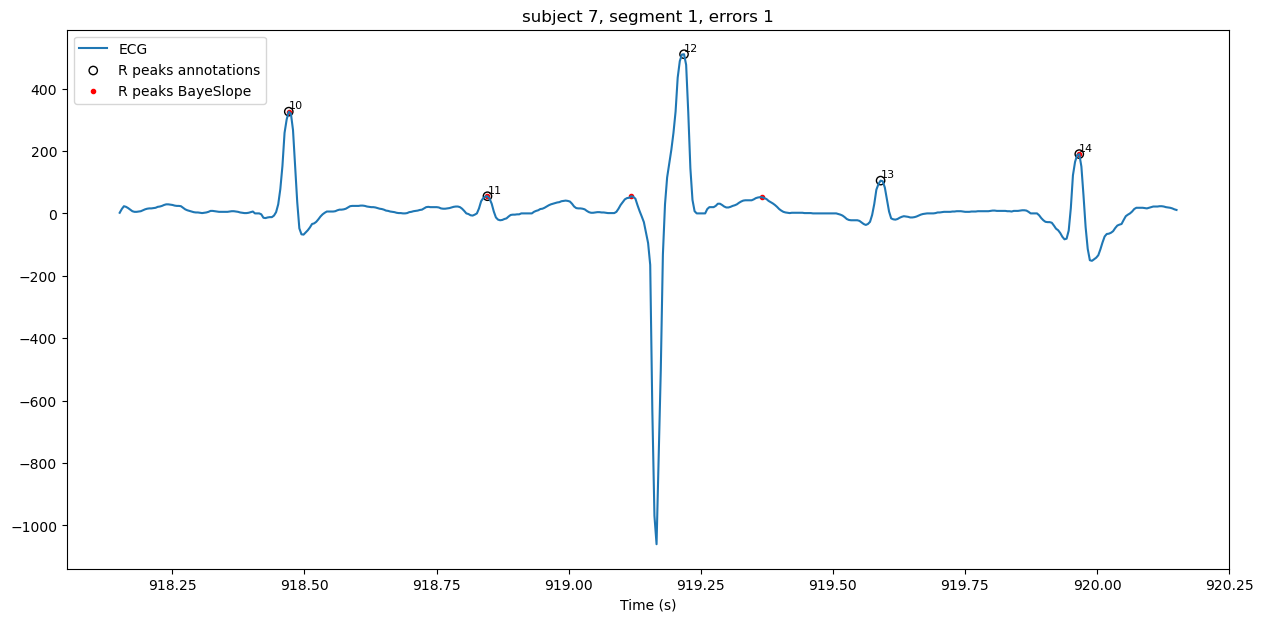

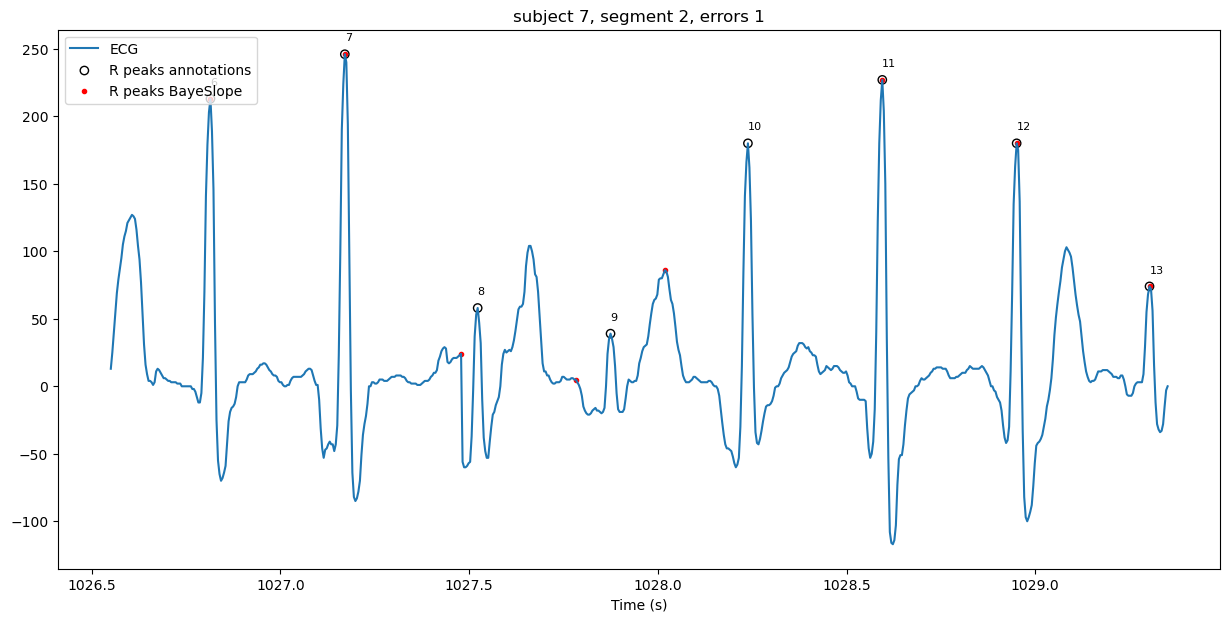

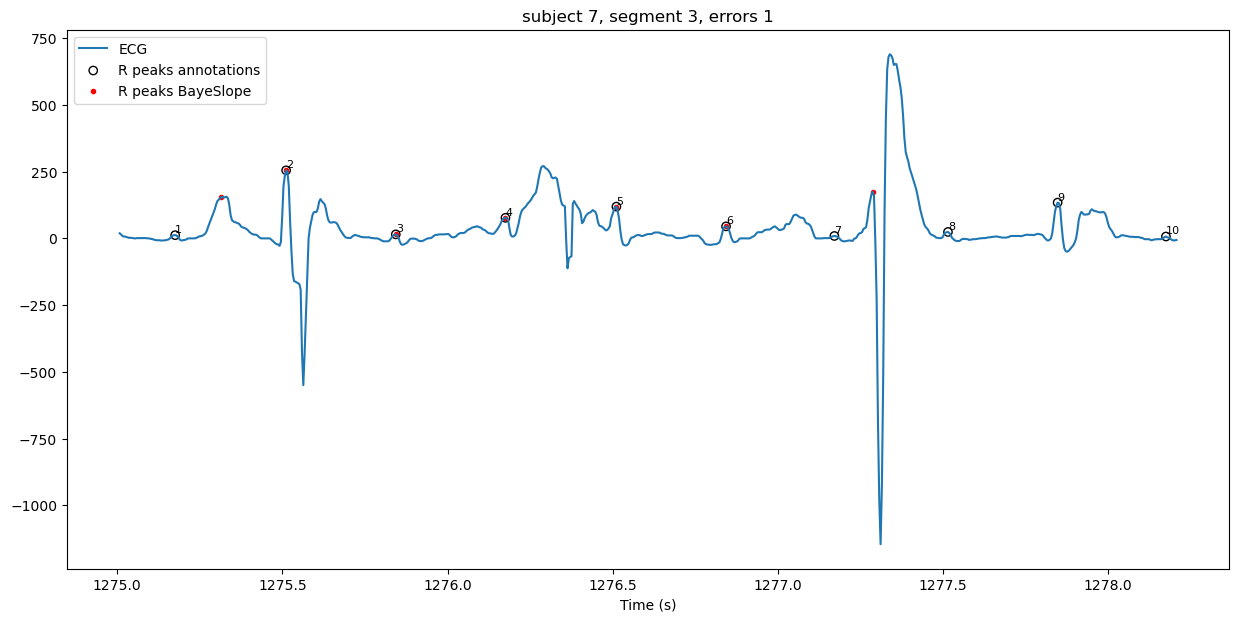

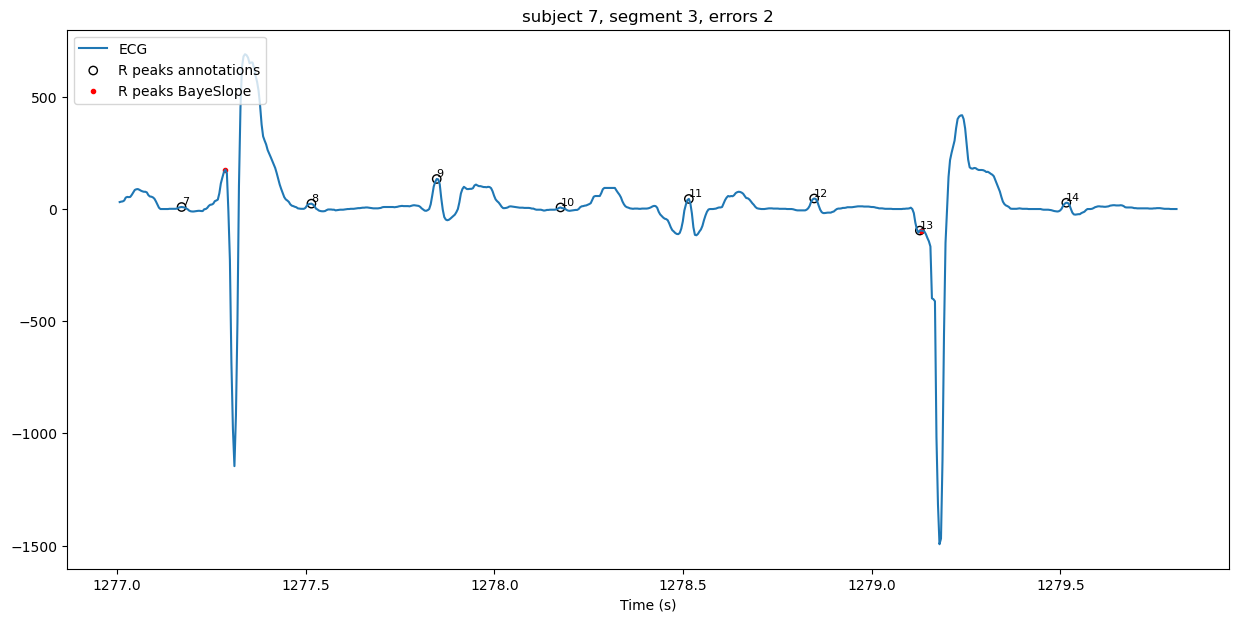

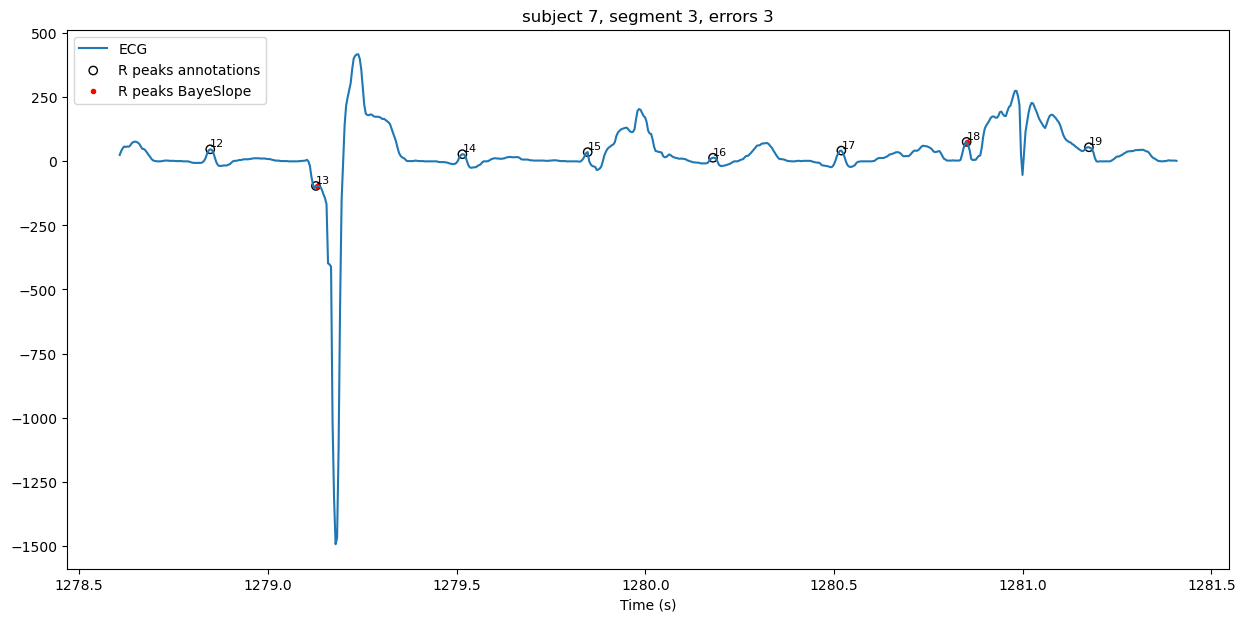

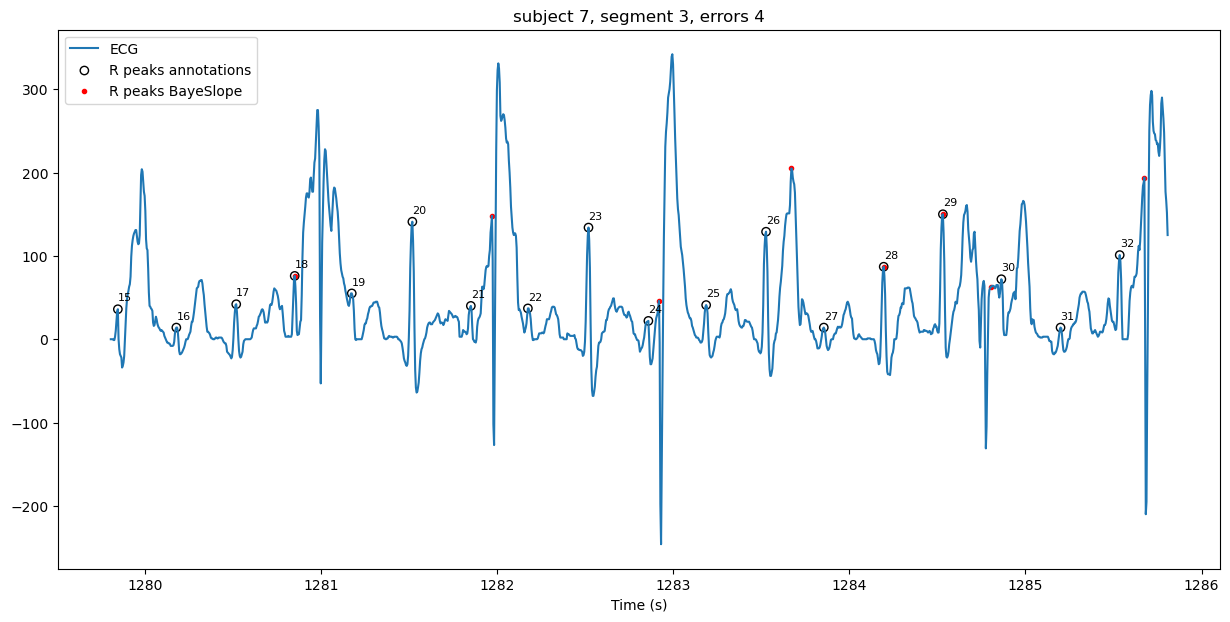

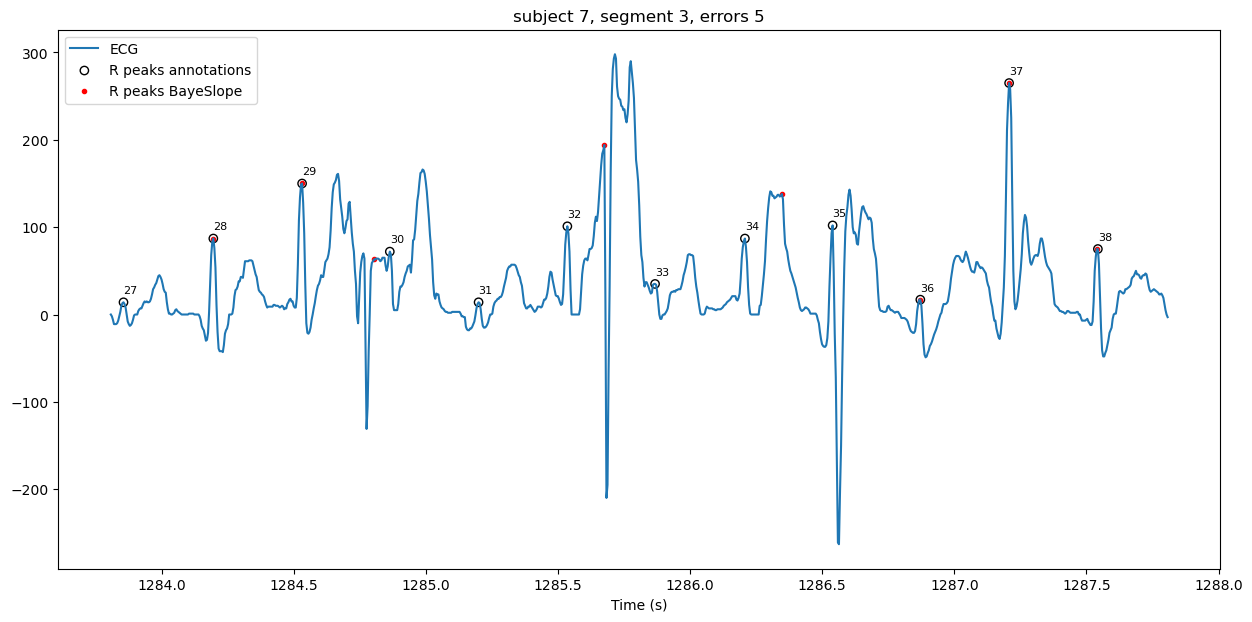

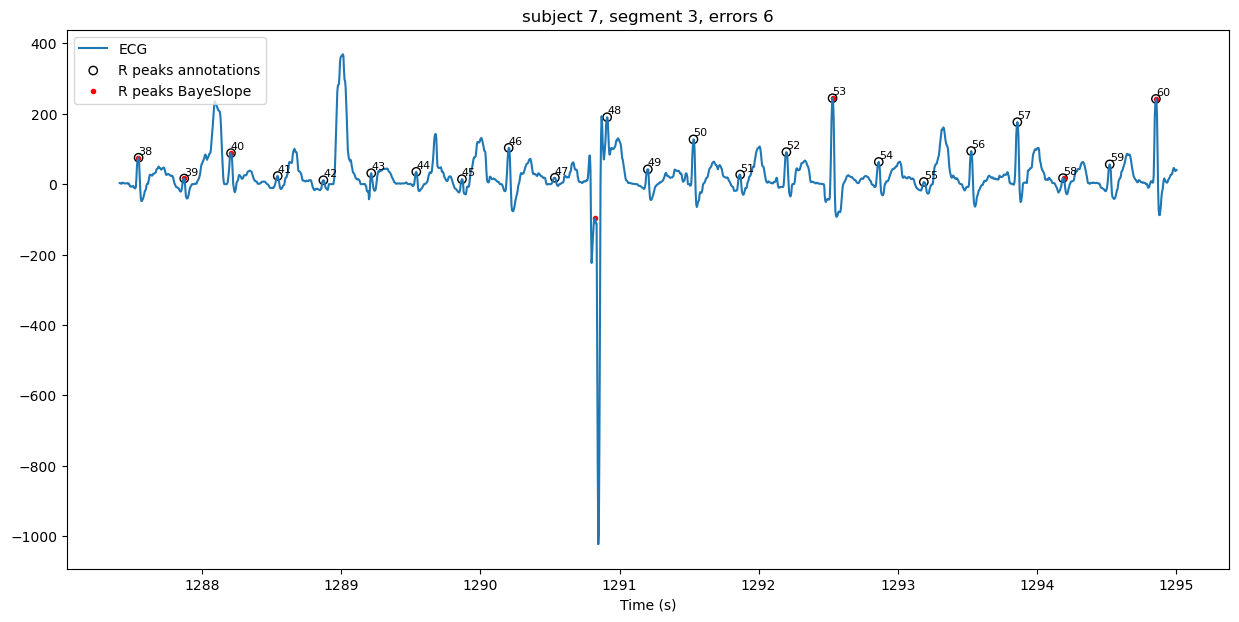

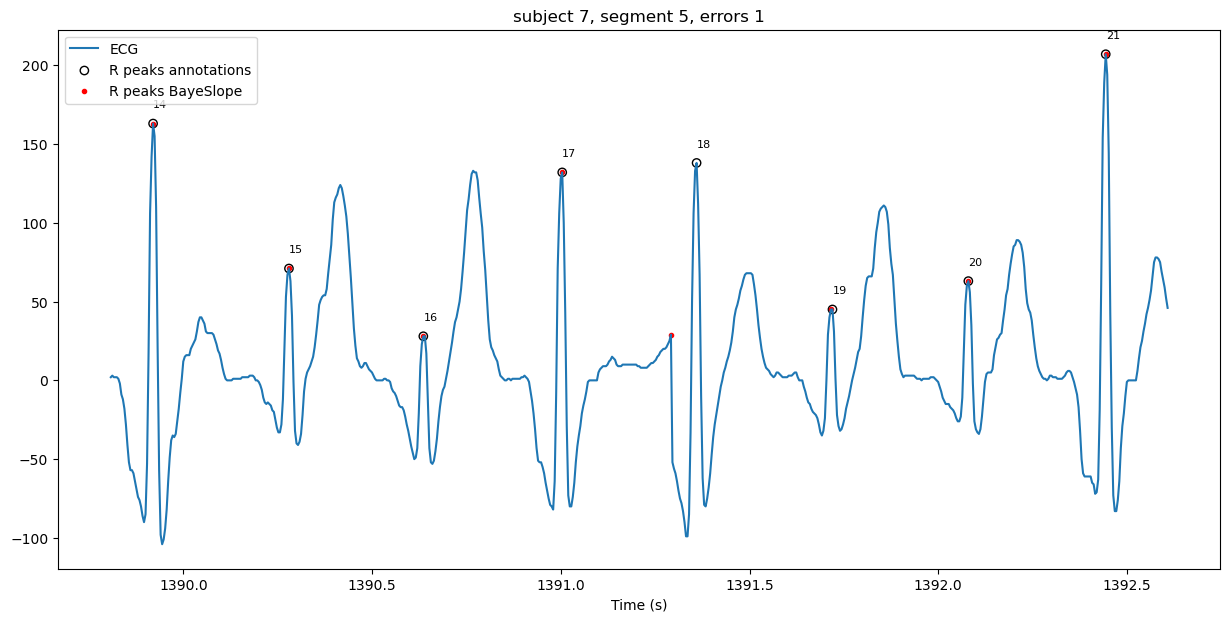

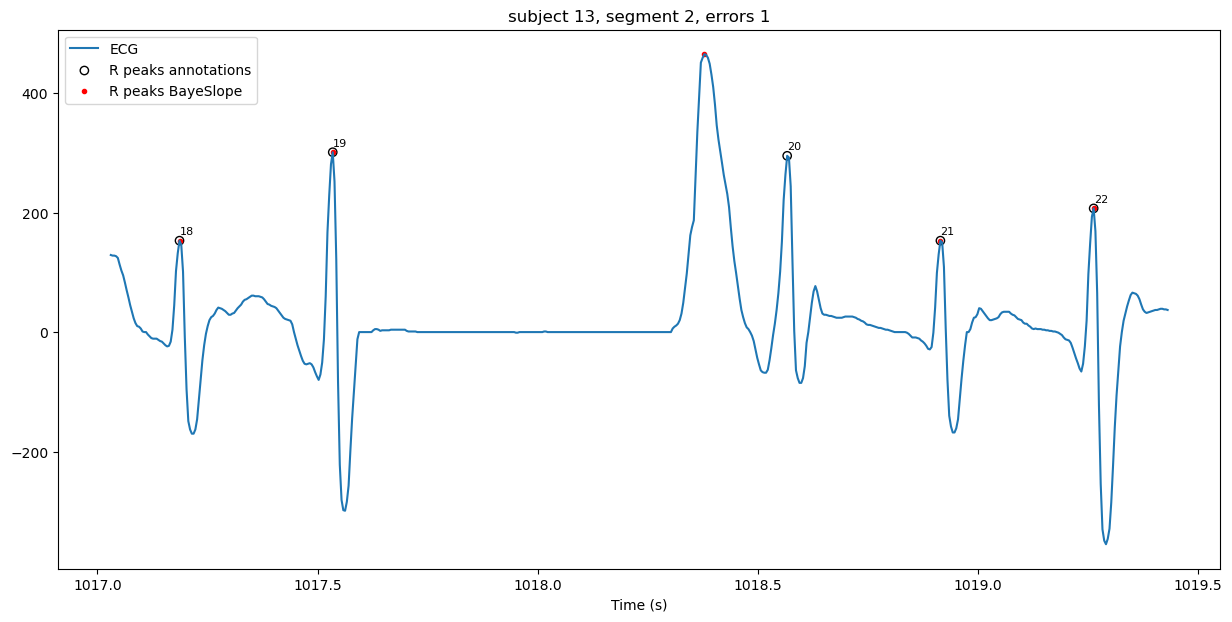

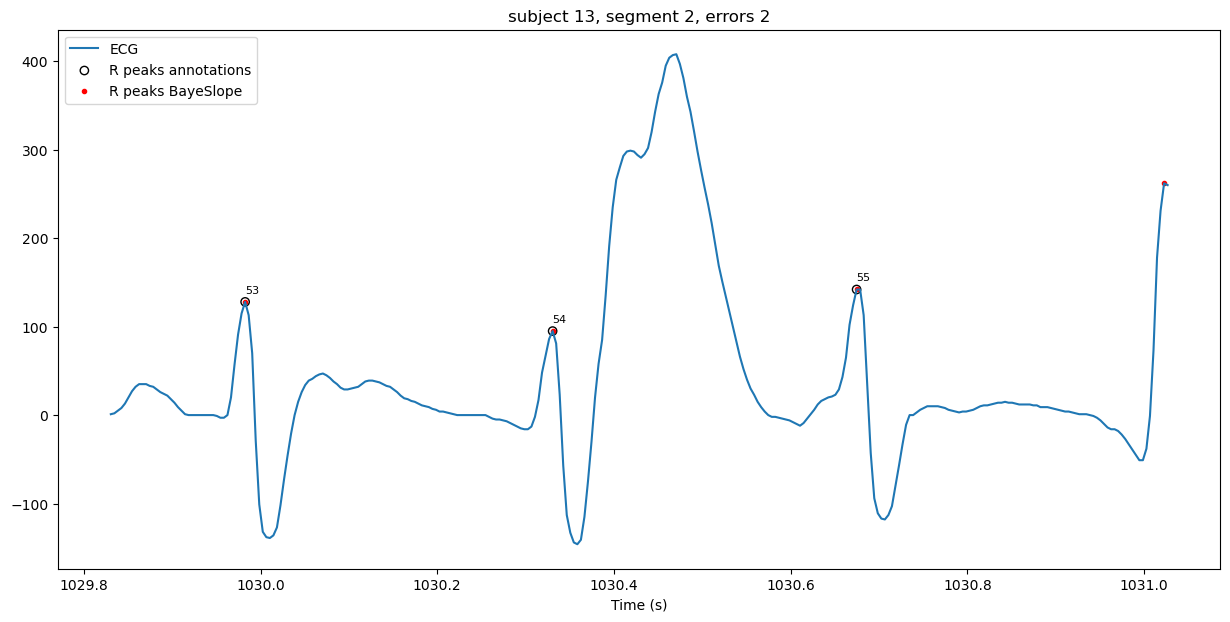

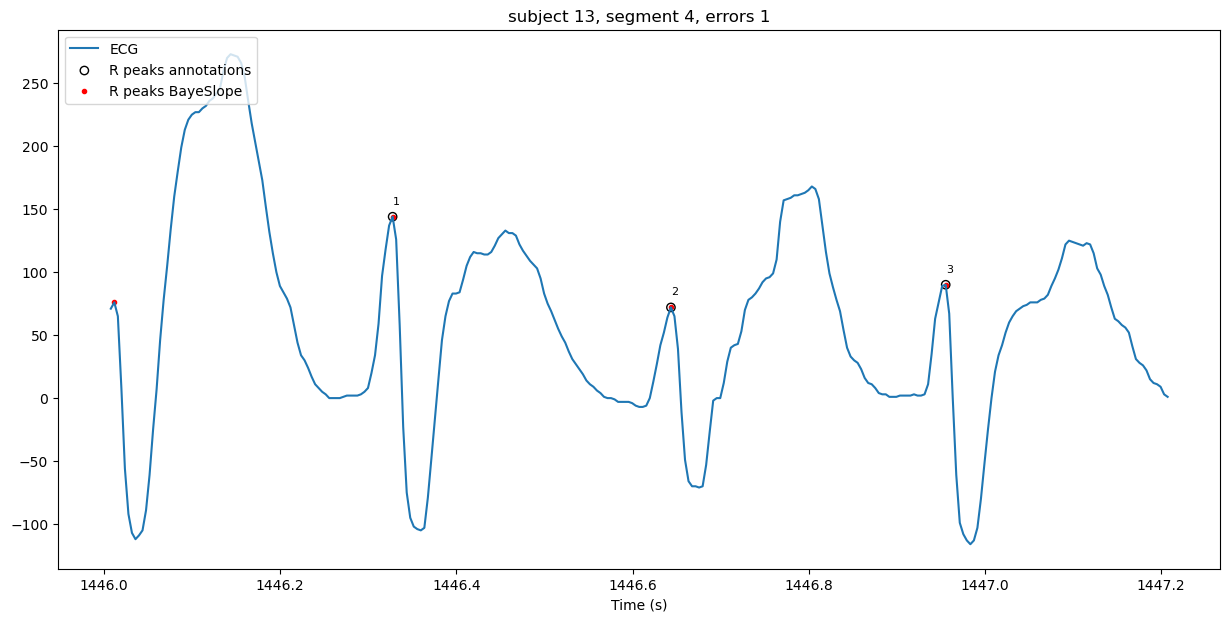

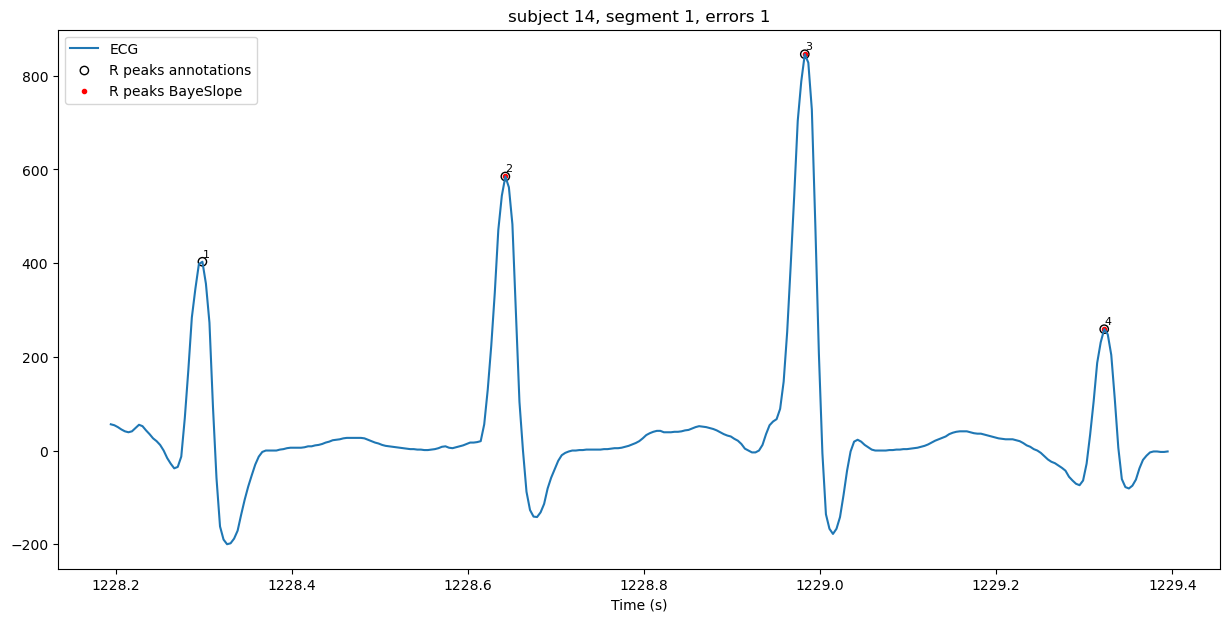

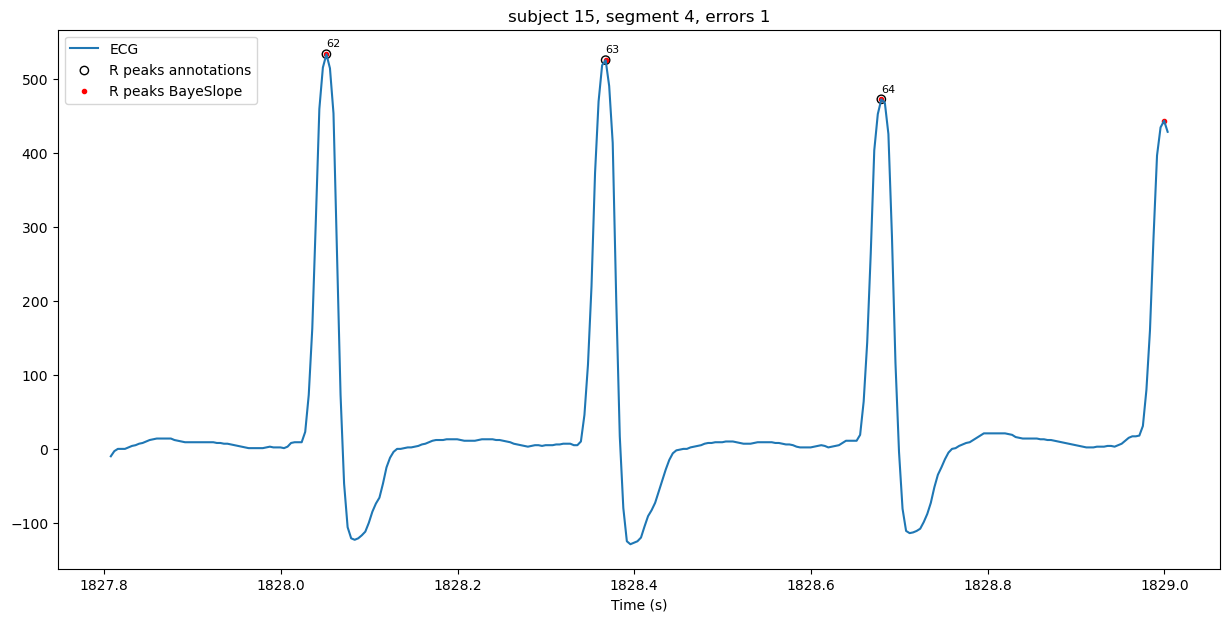

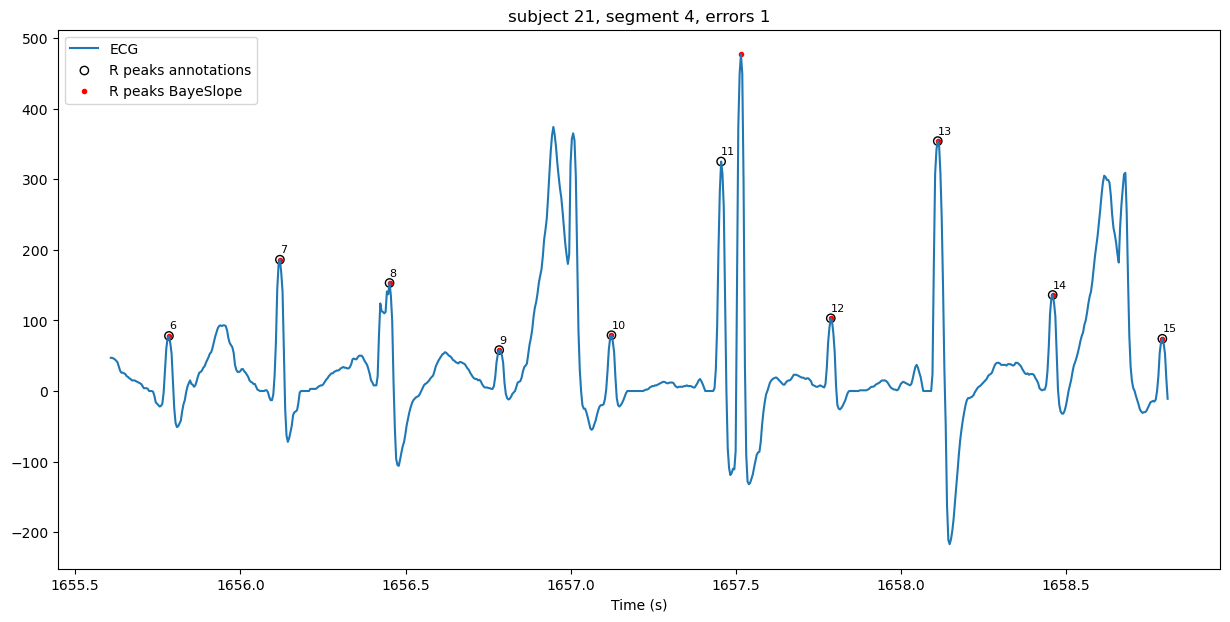

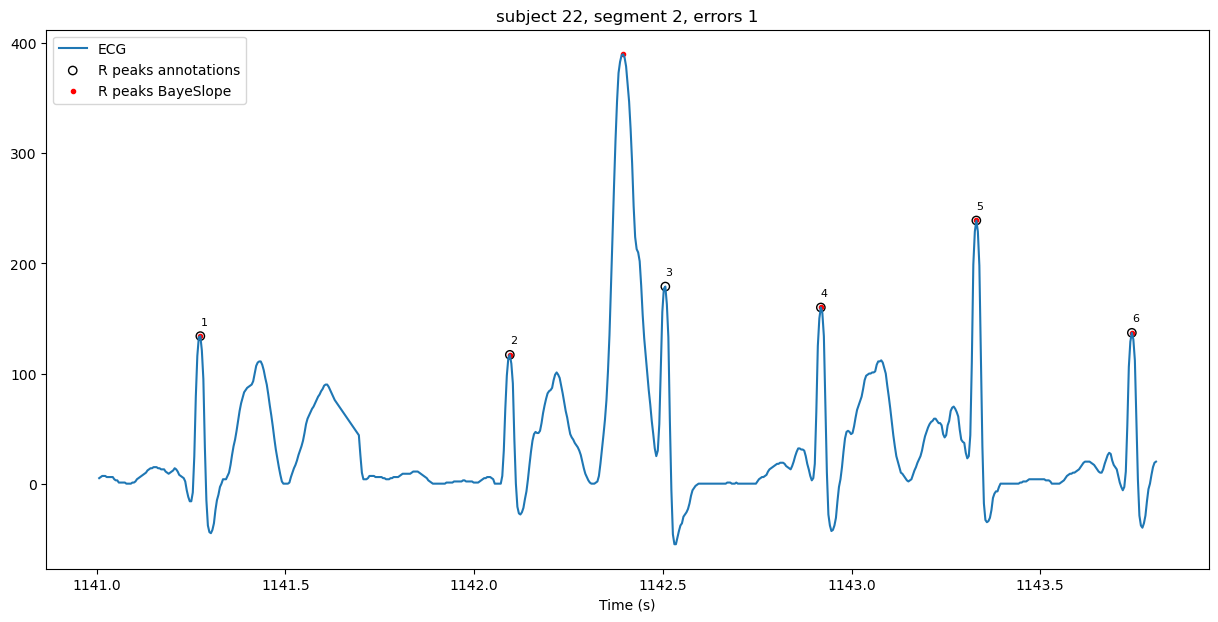

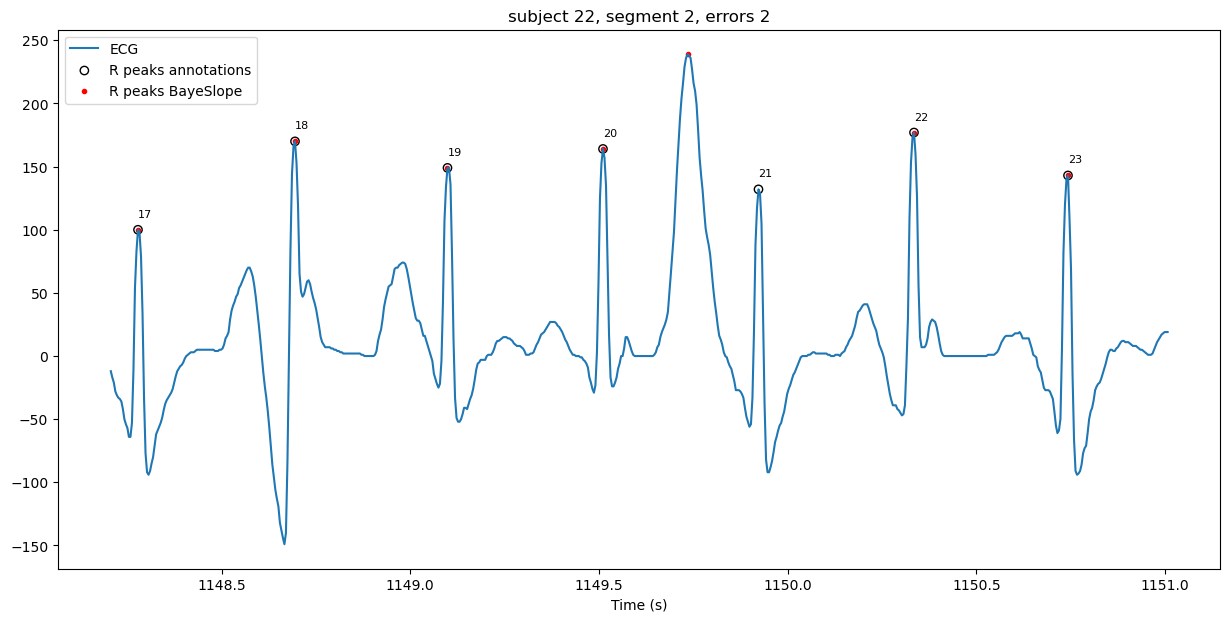

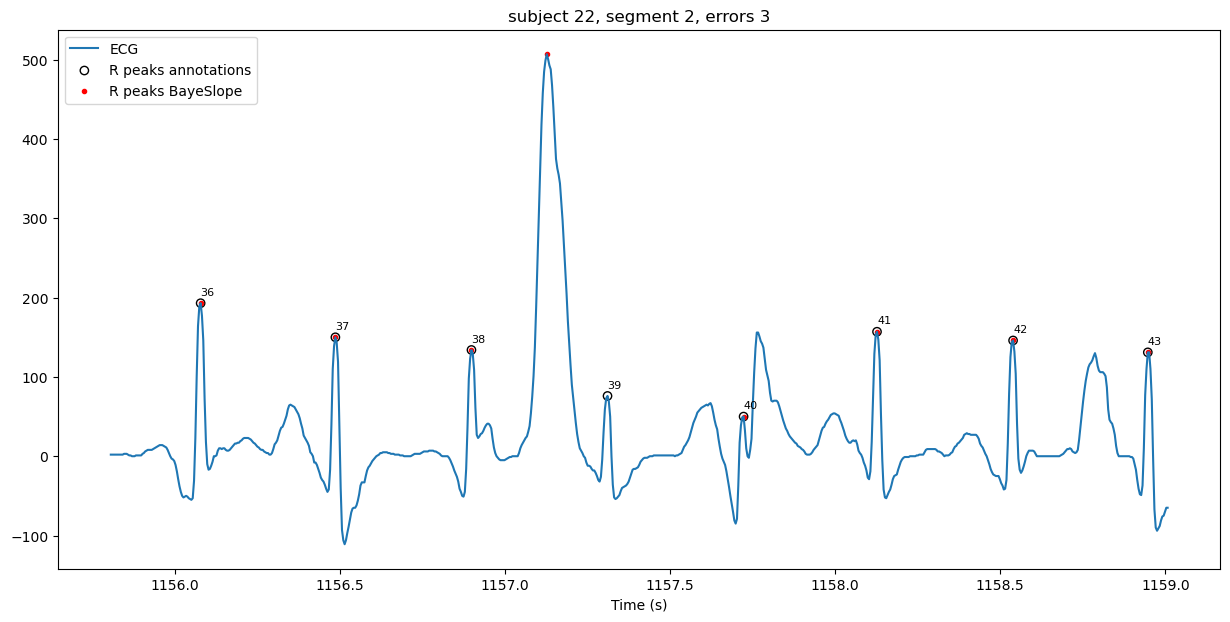

In [8]:
for r in Errors.itertuples():
    plot_segment_part(r.subject, r.segment, r.error_id, r.start, r.end)

# Error labels

In [9]:
def segment_peaks(nsub, nseg, start=0, end=5000):

    # ECG segment
    ecg_mat = loadmat(f"ECG_segments_data/ecg_segments/ecg_sub{nsub}_seg{nseg}.mat")
    ecg = pd.DataFrame({
        't': ecg_mat['t'].squeeze(),
        'signal': ecg_mat['ecg'].squeeze()
    })
    ecg = ecg.reset_index()
    ecg.rename(columns={'index': 'idt'}, inplace=True)
    
    # Annotations
    peaks = pd.read_csv(f'ECG_segments_data/manual_annotations/ecg_sub{nsub}_seg{nseg}_labels.csv', header=None)
    peaks = peaks.reset_index()
    peaks.rename(columns={'index':'id_label', 0: 'idt', 1: 'label_desc', 2: 'label'}, inplace=True)
    
    # BayeSlope
    bayeslope_mat = loadmat(f'ECG_segments_data/Rpeaks_BayeSlope_Pulp/Rpeaks_BayeSlope_sub{nsub}_seg{nseg}.mat')
    bayeslope_array = bayeslope_mat['R_bs_cut']-1 # there is an error in the indexing
    bayeslope = pd.DataFrame(bayeslope_array)
    bayeslope = bayeslope.reset_index()
    bayeslope.rename(columns={'index':'id_BayeSlope', 0: 'idt'}, inplace=True)
    bayeslope['BayeSlope']='R'

    # Error class labels
    if (nsub, nseg)==(7, 5):
        labels = ['No-Error']*len(bayeslope_array)
        labels[17] = 'Noise'
        missed = ['--']*peaks.shape[0]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat') and os.path.exists(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat'):
        error_labels = loadmat(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat')
        labels = error_labels['labels_error_type_bs'].squeeze()
        labels = [x[0] for x in labels]
        error_missed = loadmat(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat')
        missed = error_missed['labels_missed_manann'].squeeze()
        missed = [x[0] for x in missed]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat'):
        error_labels = loadmat(f'ECG_segments_data/error_class_mannual/labels_error_type_bs_sub{nsub}_seg{nseg}.mat')
        labels = error_labels['labels_error_type_bs'].squeeze()
        labels = [x[0] for x in labels]
        missed = ['--']*peaks.shape[0]
    elif os.path.exists(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat'):
        error_missed = loadmat(f'ECG_segments_data/error_class_mannual/labels_missed_manann_sub{nsub}_seg{nseg}.mat')
        missed = error_missed['labels_missed_manann'].squeeze()
        missed = [x[0] for x in missed]
        labels = ['No-Error']*len(bayeslope_array)
    else:
        labels = ['No-Error']*len(bayeslope_array)
        missed = ['--']*peaks.shape[0]
    bayeslope['error_class_label'] = labels
    peaks['error_missed_label'] = missed
    
    # Merges
    ECG = ecg.merge(bayeslope, how='left', on='idt')\
        .merge(peaks[['id_label', 'idt', 'label', 'error_missed_label']], how='left', on='idt')
    return ECG[(ECG['idt']>=start) & (ECG['idt']<=end)]

In [10]:
def plot_segment_part_class(nsub, nseg, npart, start, end):

    # ECG
    ECG = segment_peaks(nsub, nseg, start, end)
    peaks_annotations = ECG[ECG['label']=='R']
    peaks_bayeslope = ECG[ECG['BayeSlope']=='R']
    
    # plot
    plt.figure(figsize=(15, 7))
    
    plt.plot(ECG['t'], ECG['signal'], label='ECG')
    
    plt.scatter(peaks_annotations['t'], peaks_annotations['signal'], marker='o', facecolor='none', color='k', label='R peaks annotations')
    for _, row in peaks_annotations.iterrows():
        plt.text(row['t'], row['signal']+5, str(int(row['id_label'])+1), fontsize=8, color='black')
        if row['error_missed_label']!='--':
            plt.text(row['t'], row['signal']+15, row['error_missed_label'], fontsize=8, color='black')
            
    plt.scatter(peaks_bayeslope['t'], peaks_bayeslope['signal'], marker='.', color='r', label='R peaks BayeSlope')
    for _, row in peaks_bayeslope.iterrows():
        plt.text(row['t'], row['signal']+10, str(int(row['id_BayeSlope'])+1), fontsize=8, color='red')
        if row['error_class_label']!='No-Error' and (nsub, nseg)!=(7, 3):
            plt.text(row['t'], row['signal']+15, row['error_class_label'], fontsize=8, color='red')
        elif row['error_class_label']!='No-Error' and (nsub, nseg)==(7, 3):
            plt.text(row['t'], row['signal']+50, row['error_class_label'], fontsize=8, color='red')
    plt.legend(loc='upper left')
    plt.title(f'subject {nsub}, segment {nseg}, errors {npart}')
    plt.xlabel("Time (s)")
    plt.show()

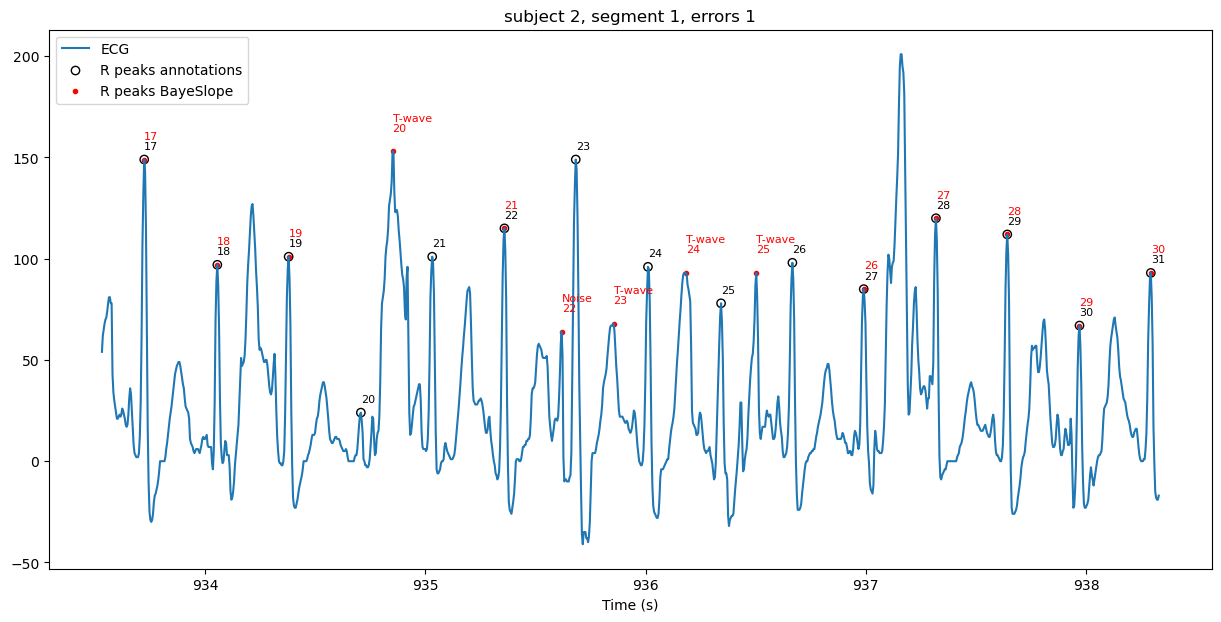

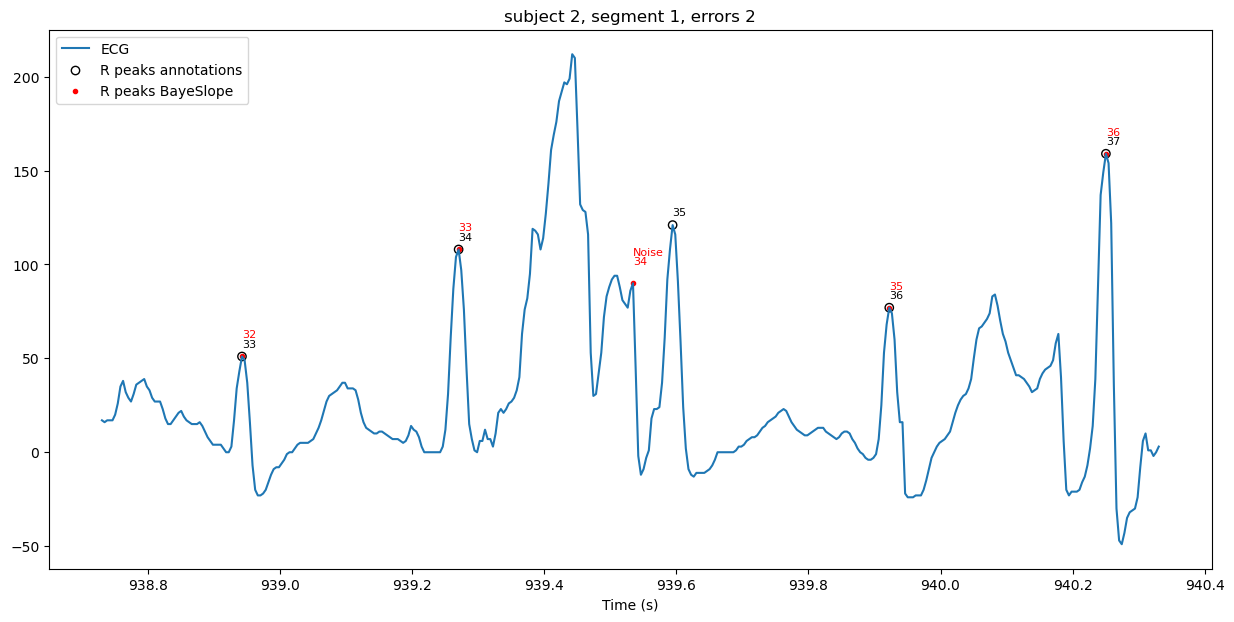

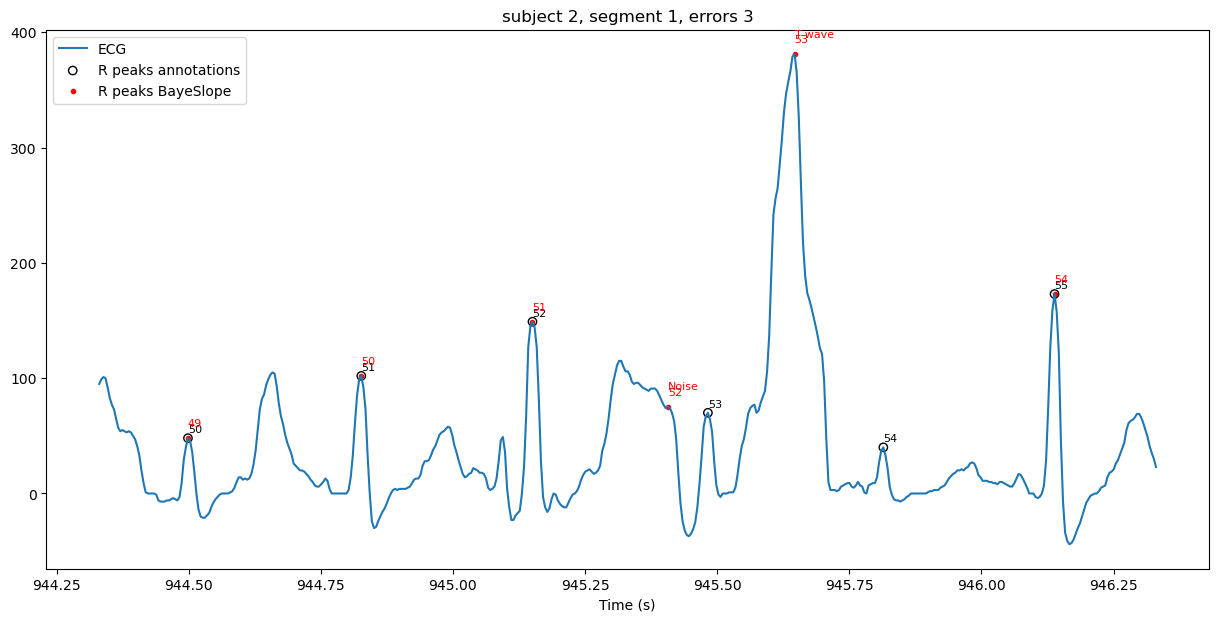

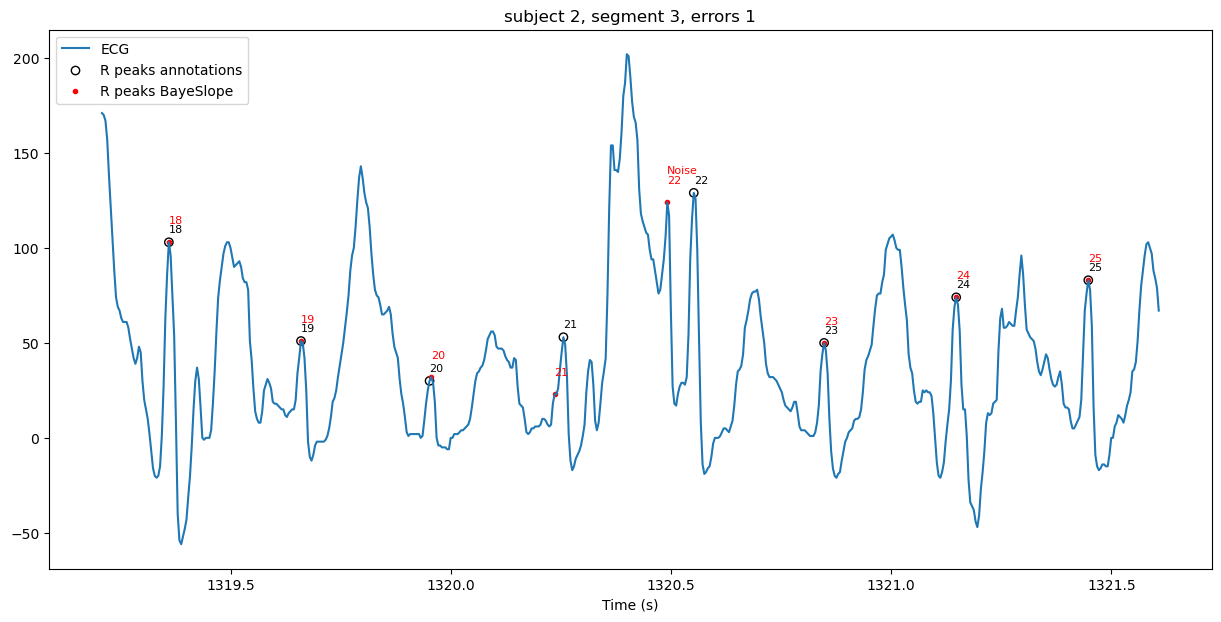

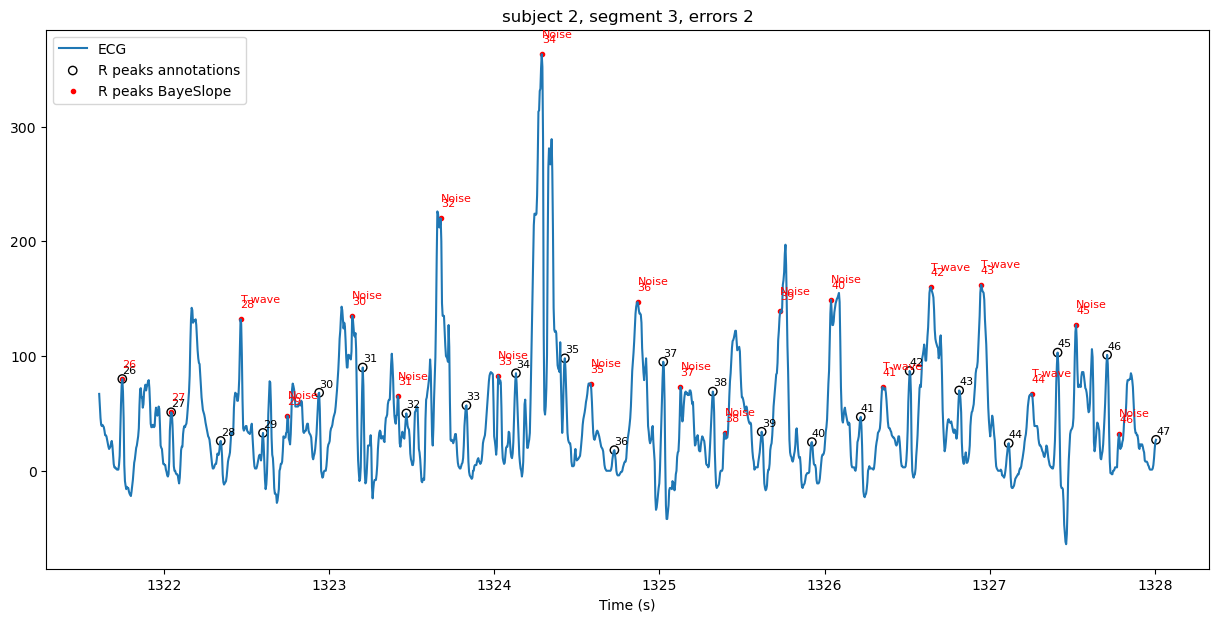

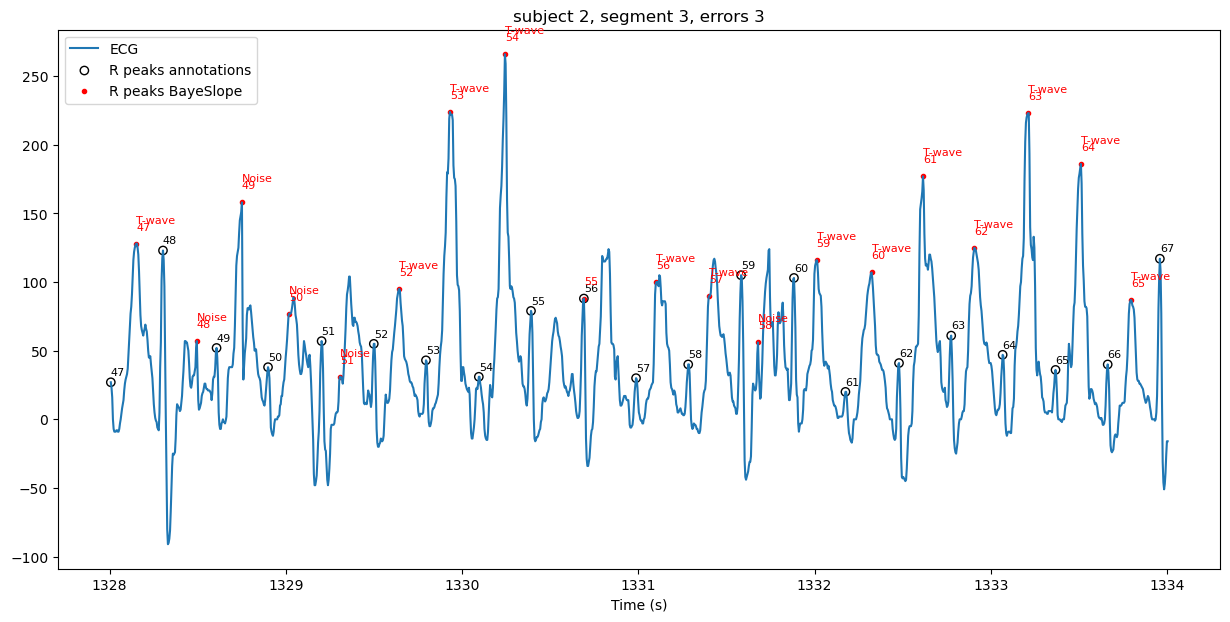

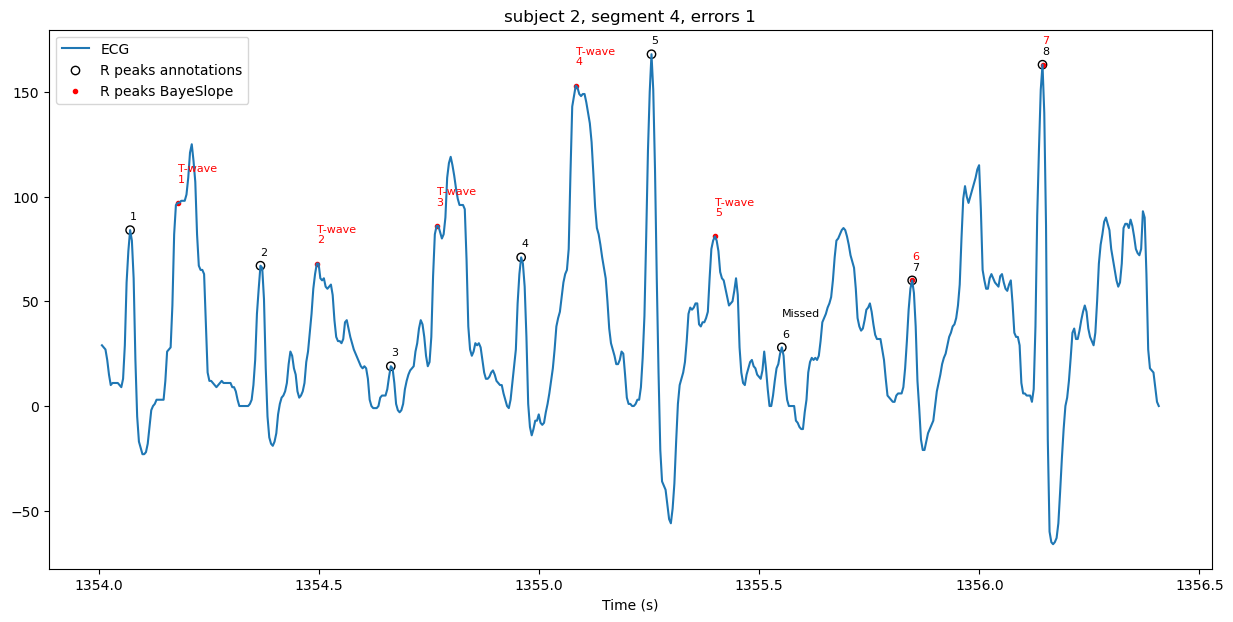

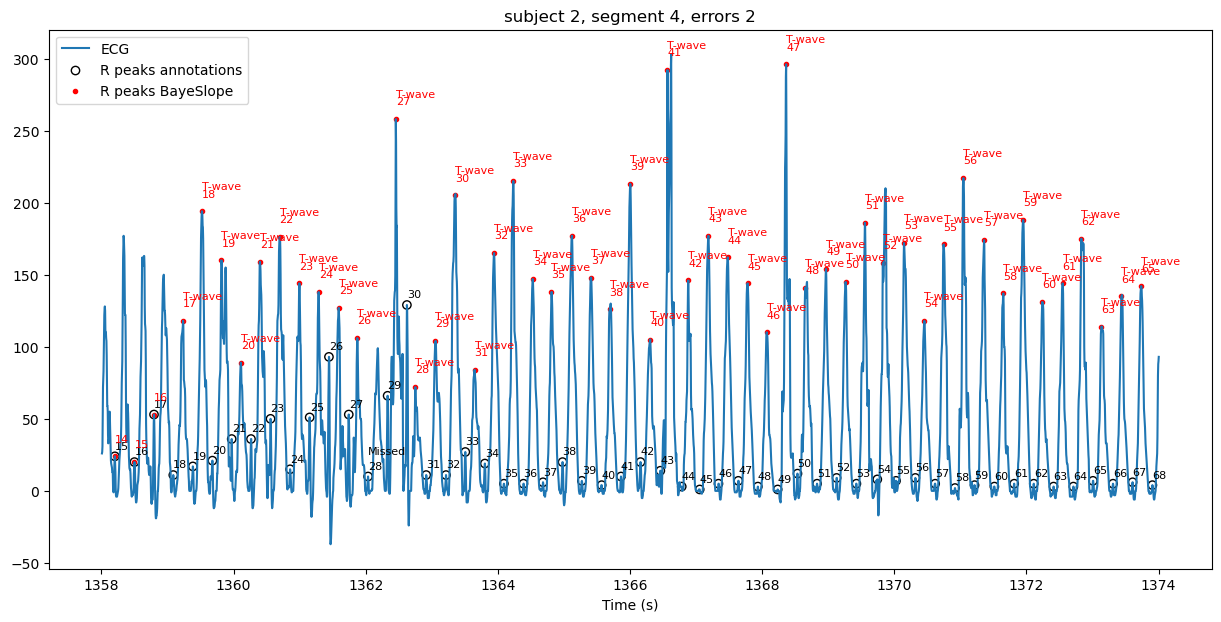

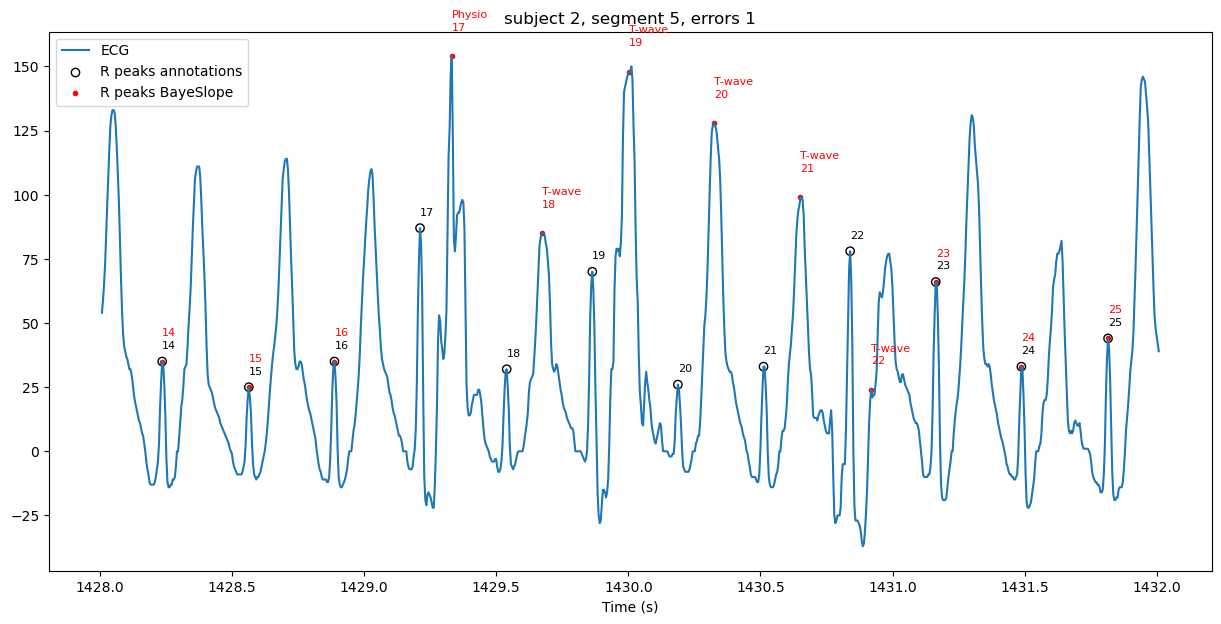

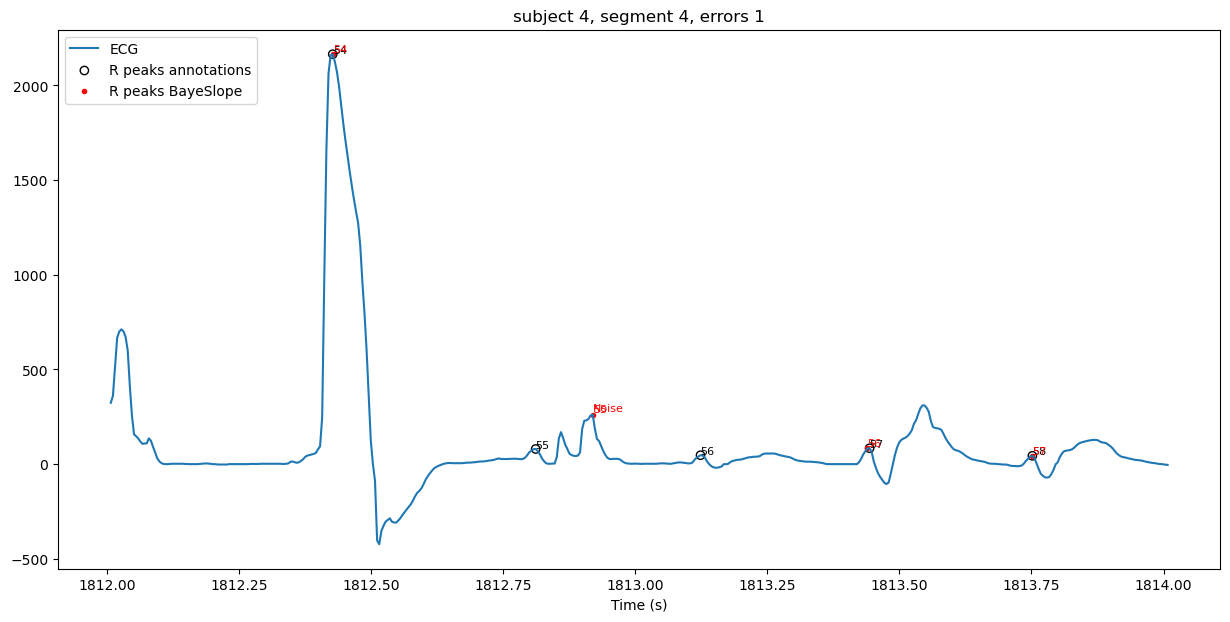

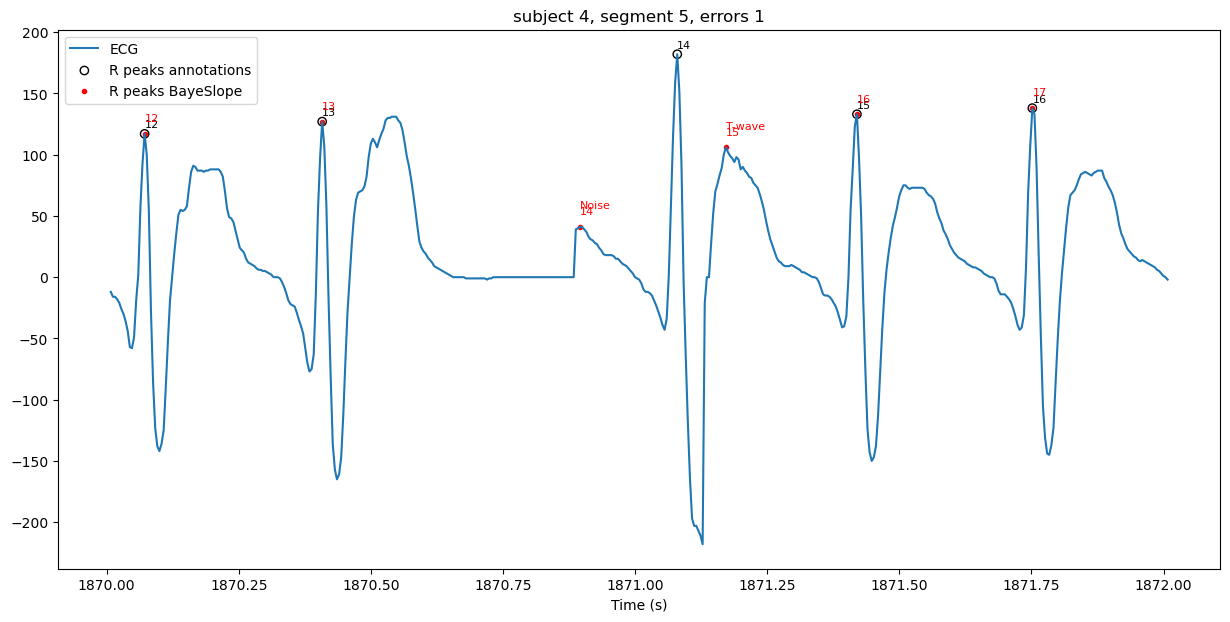

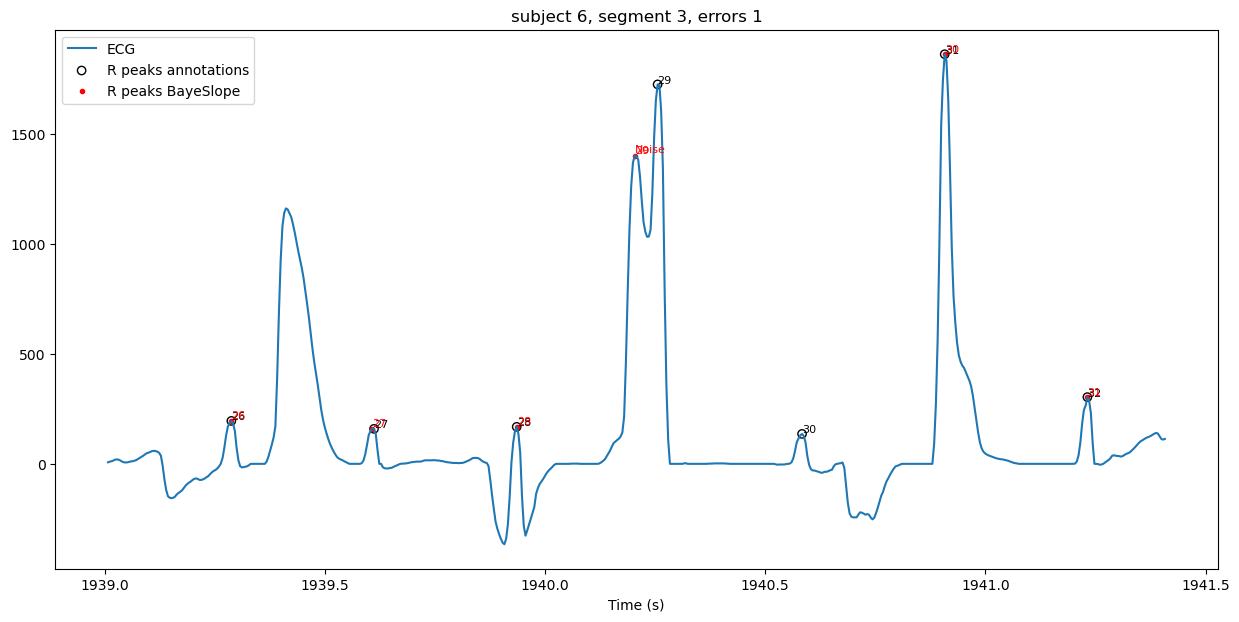

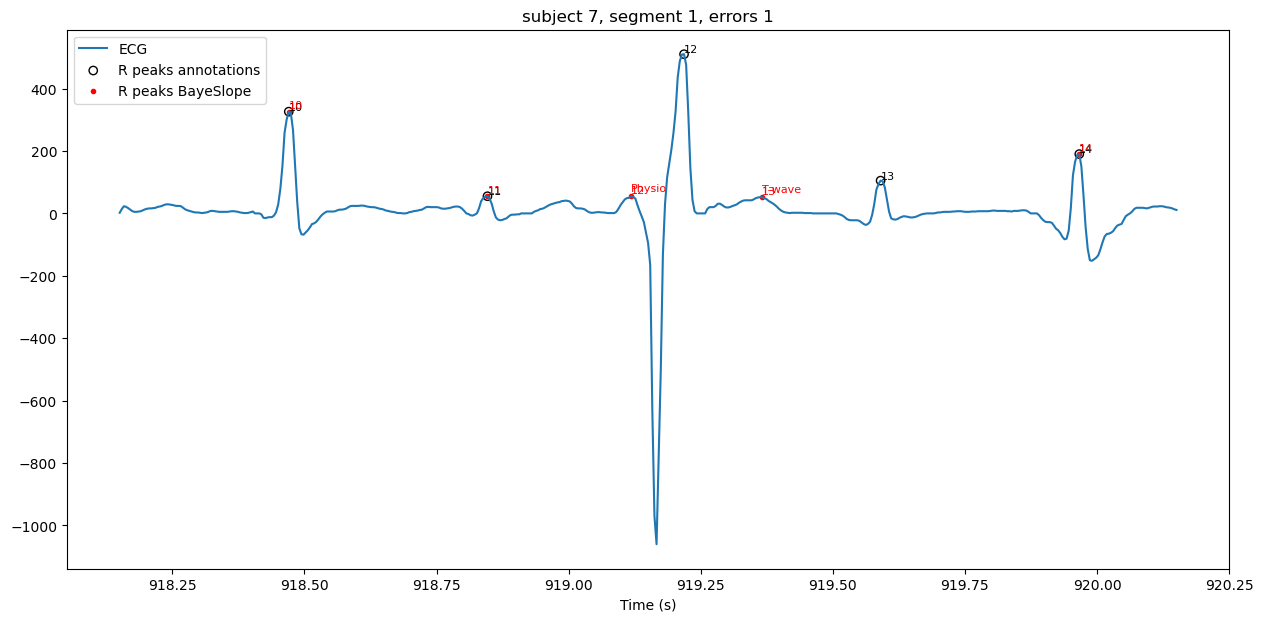

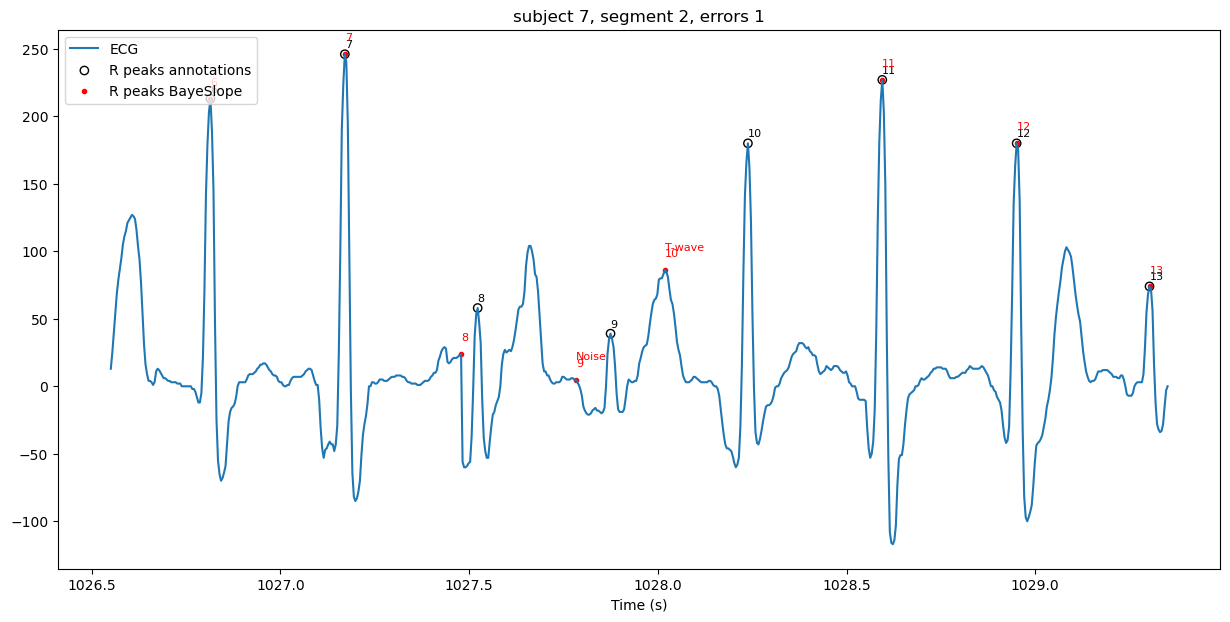

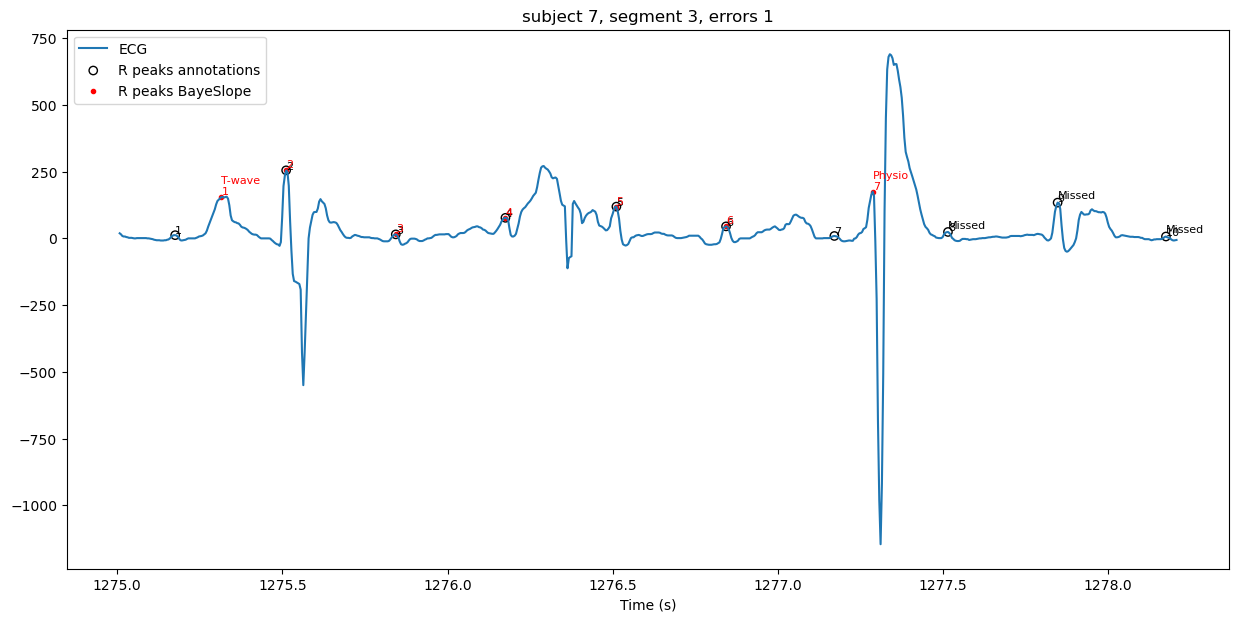

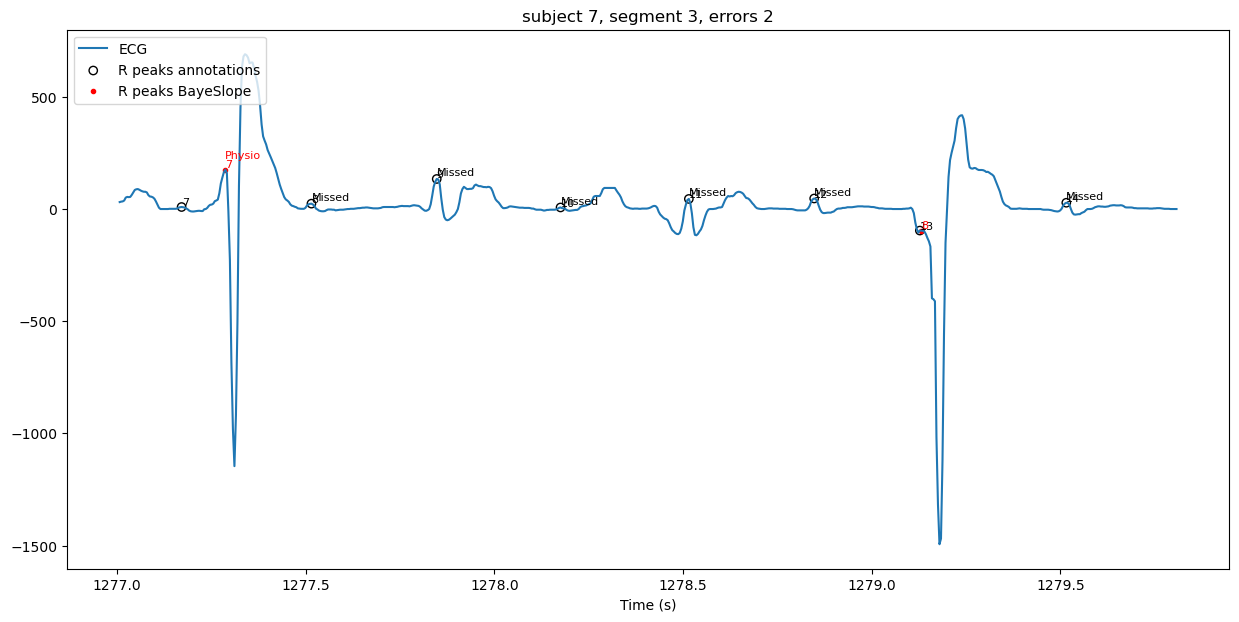

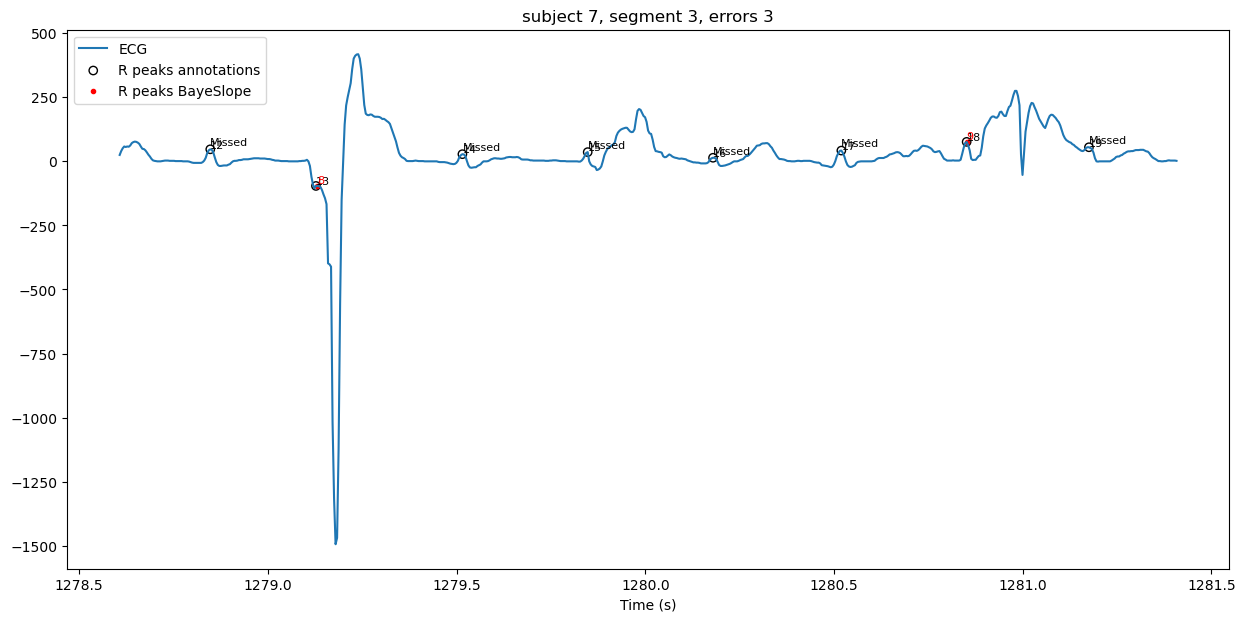

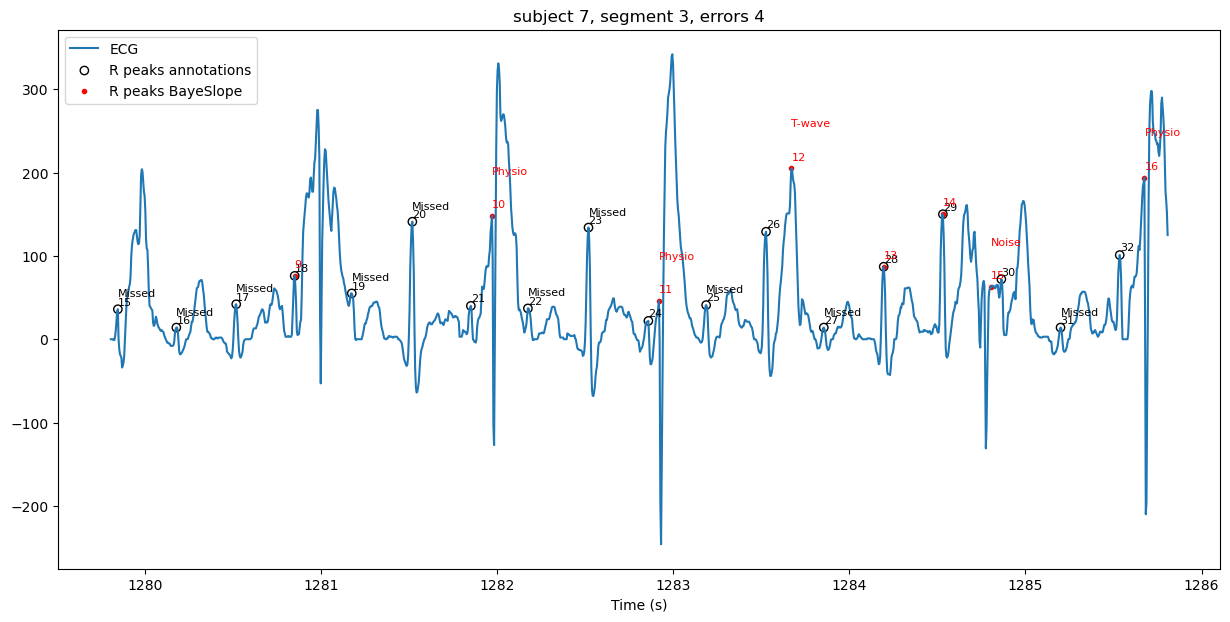

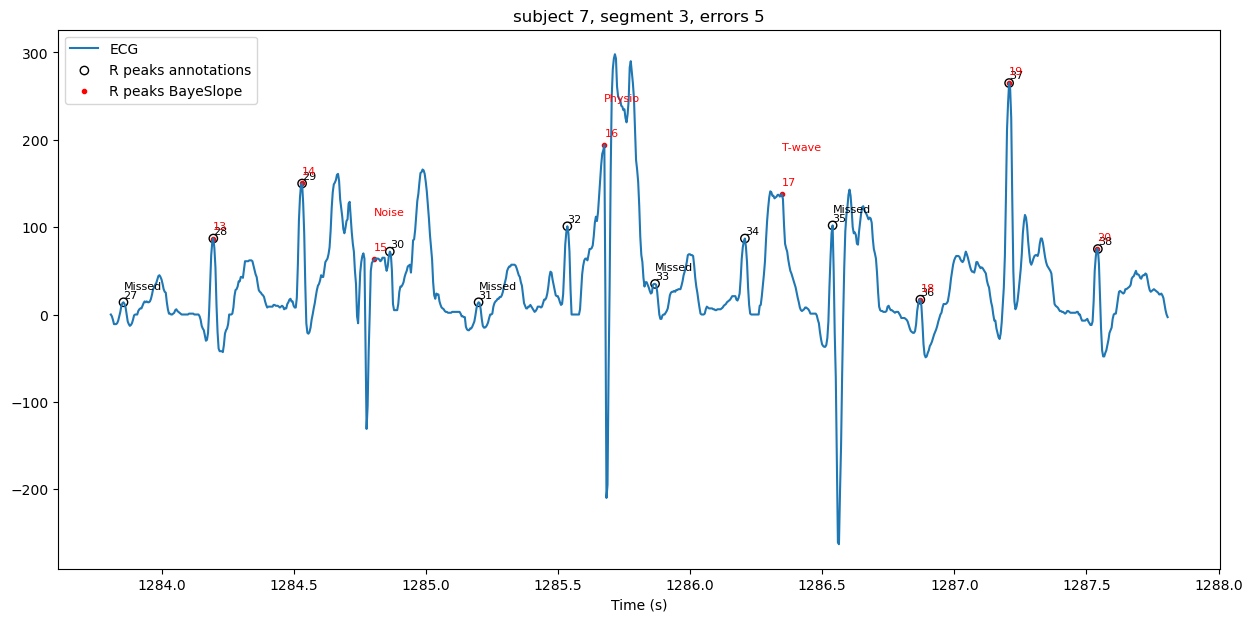

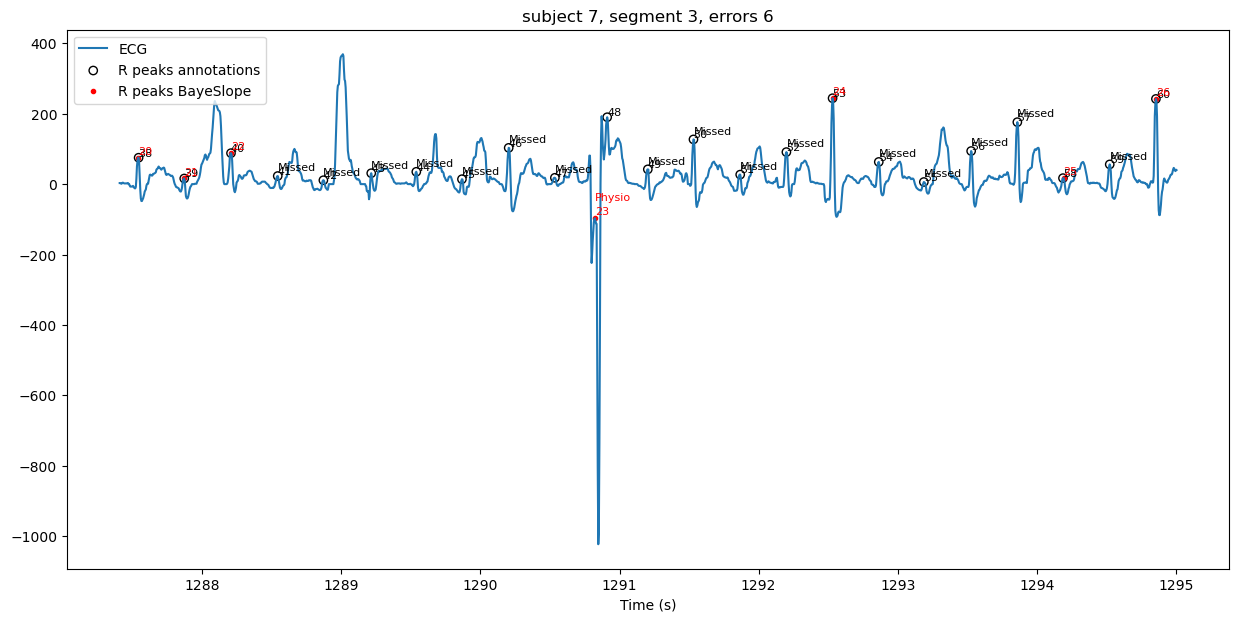

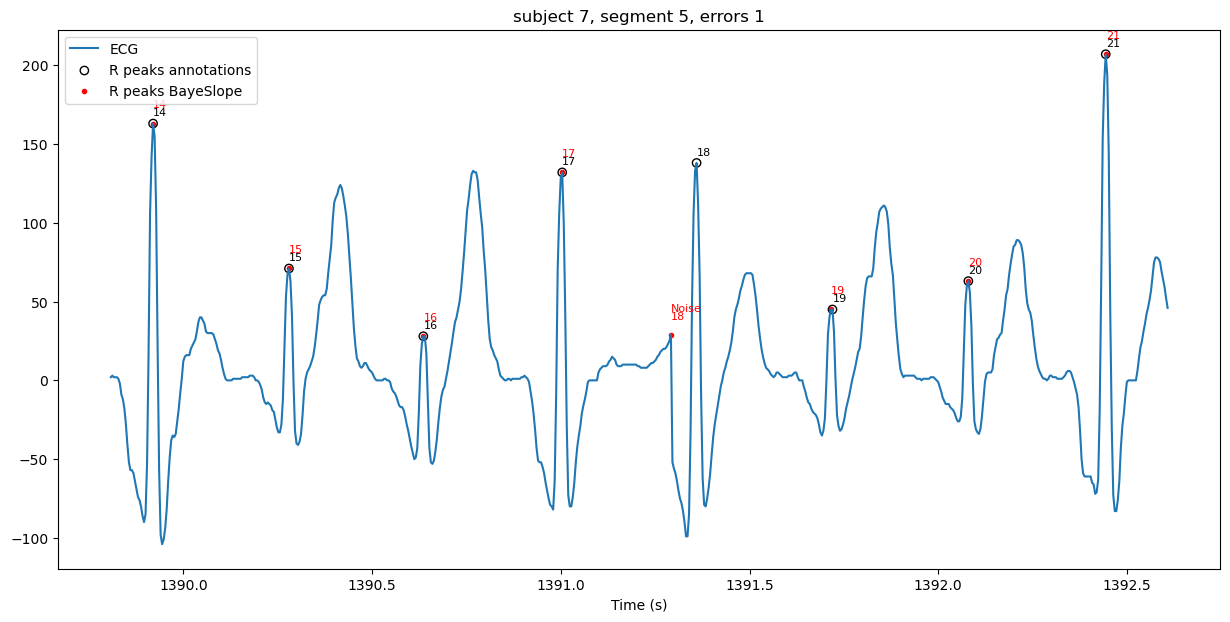

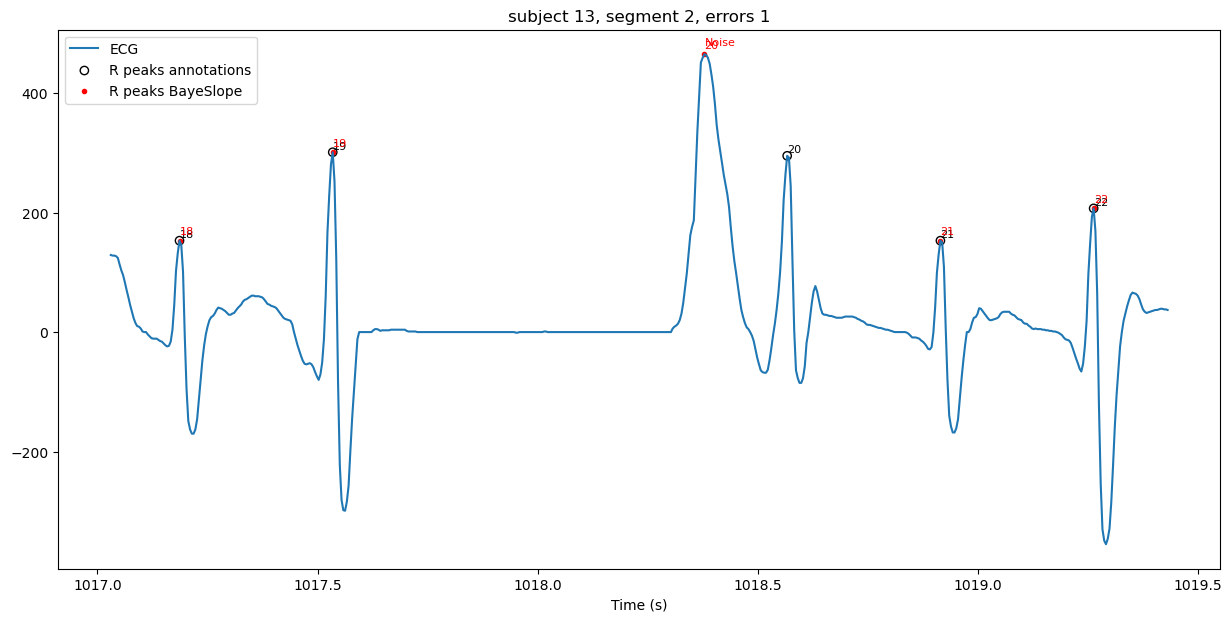

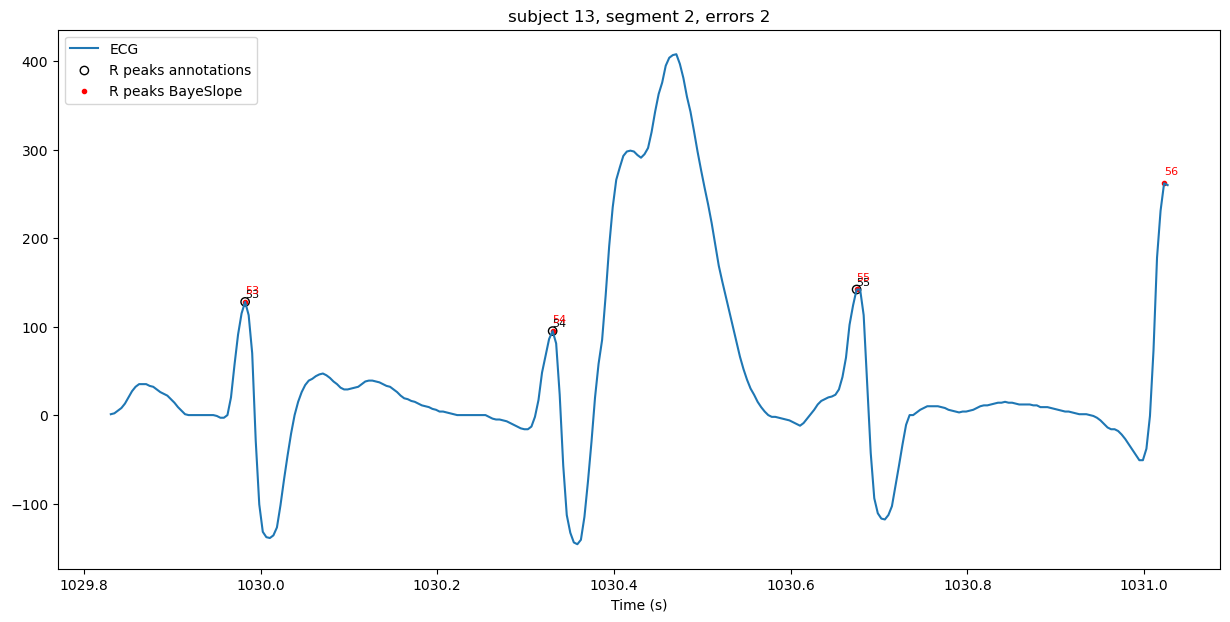

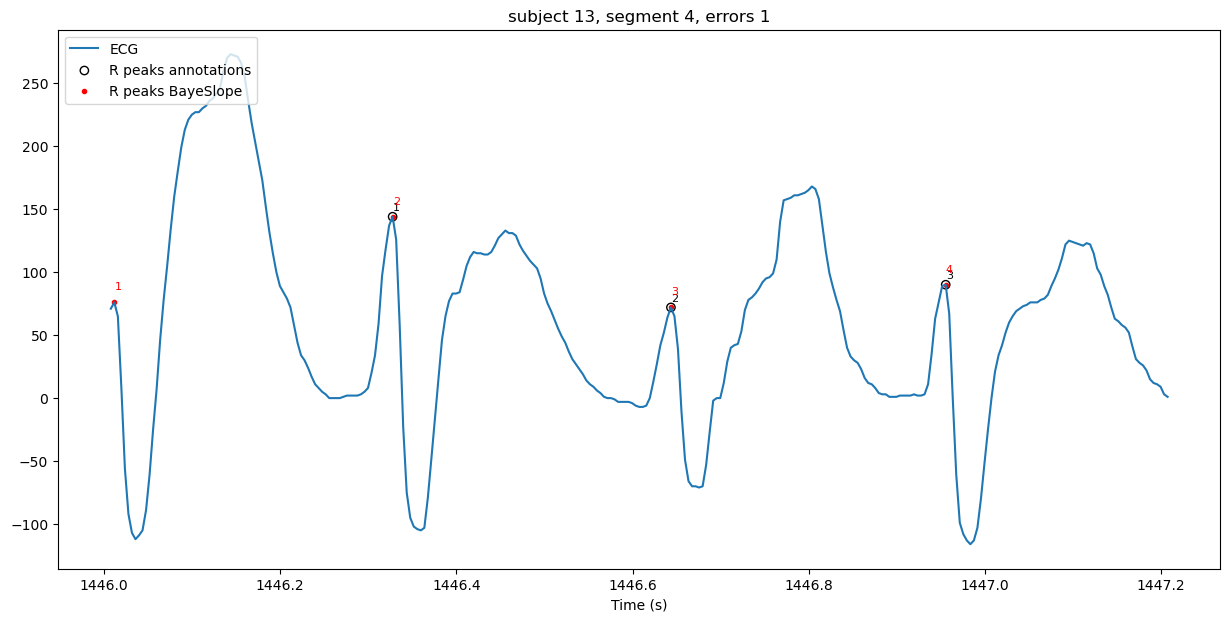

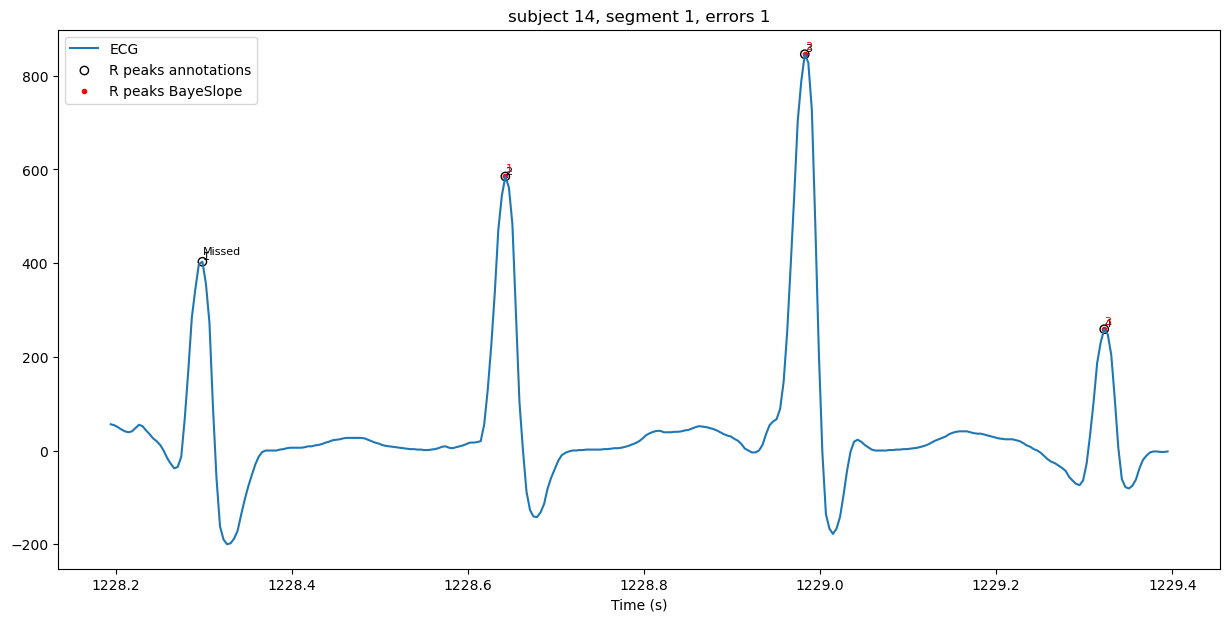

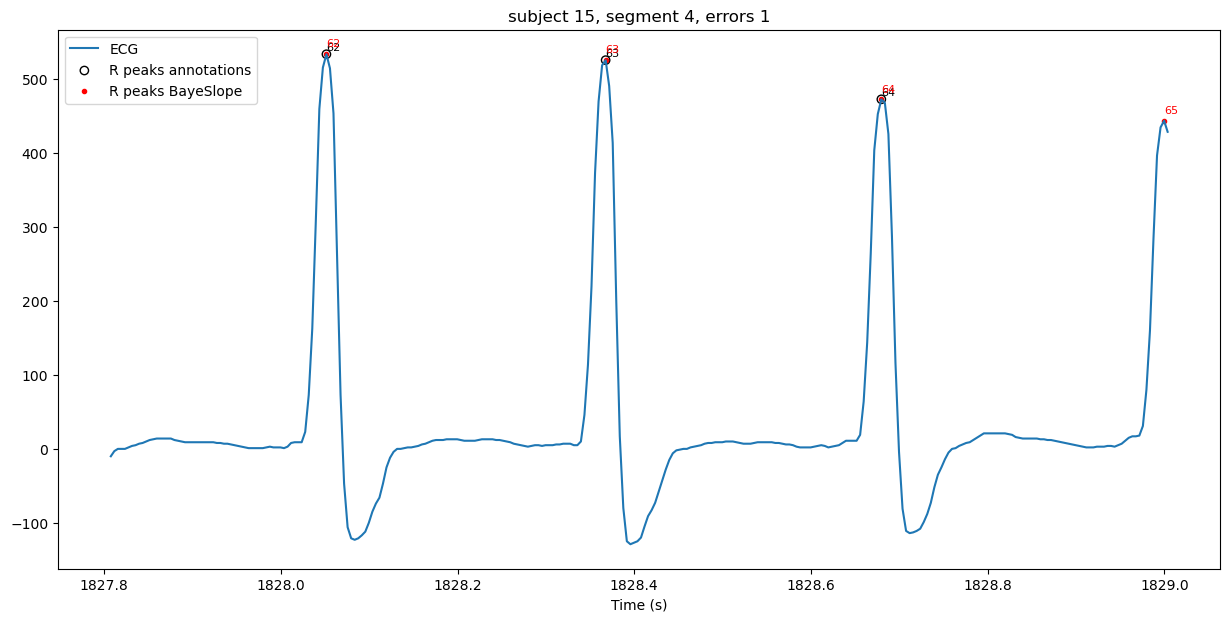

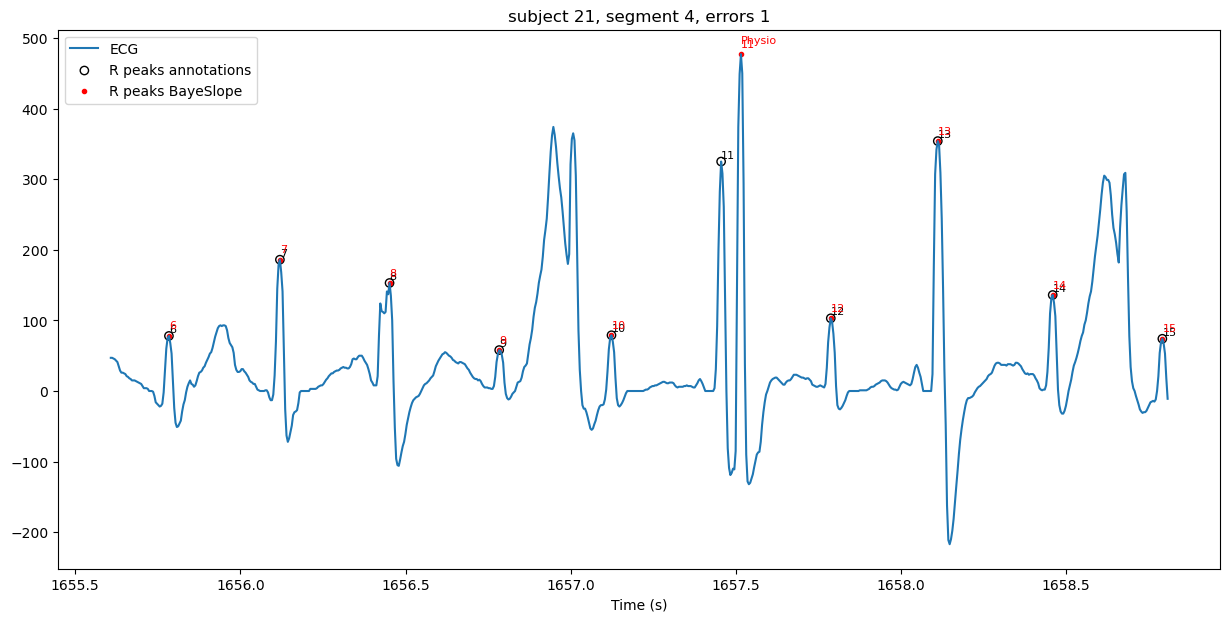

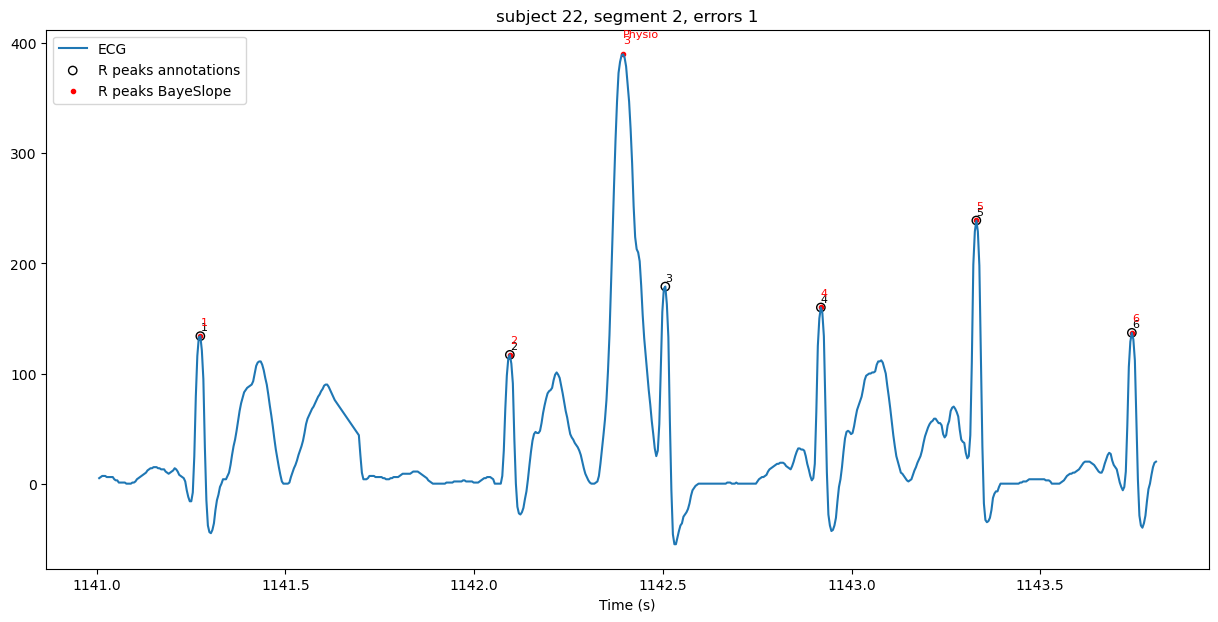

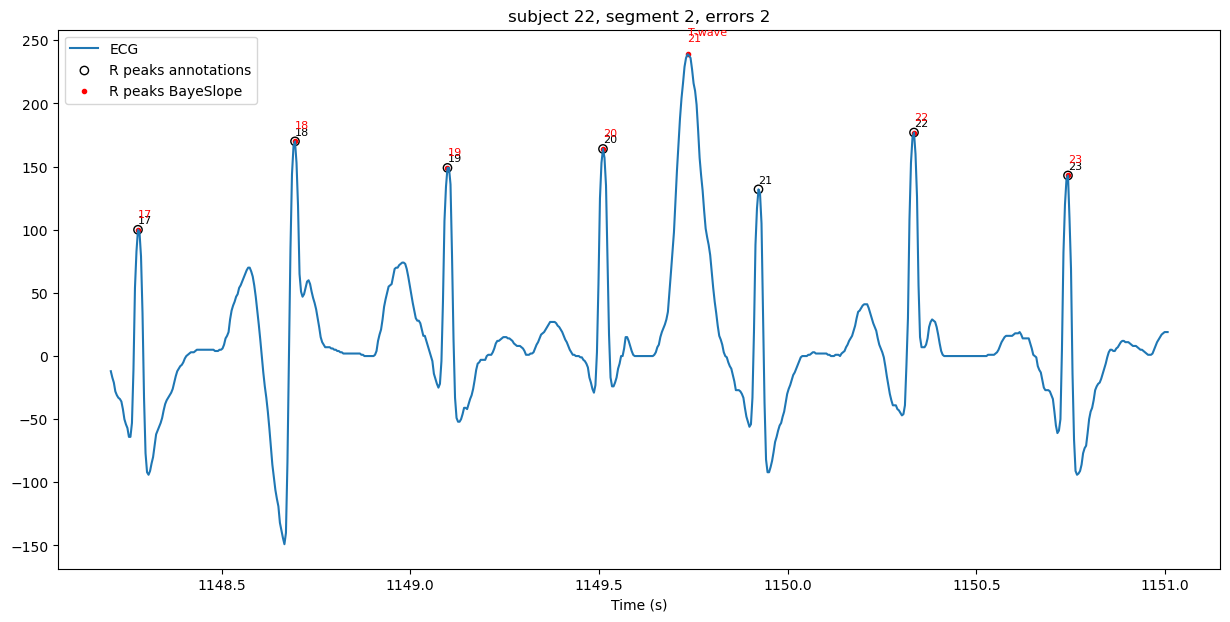

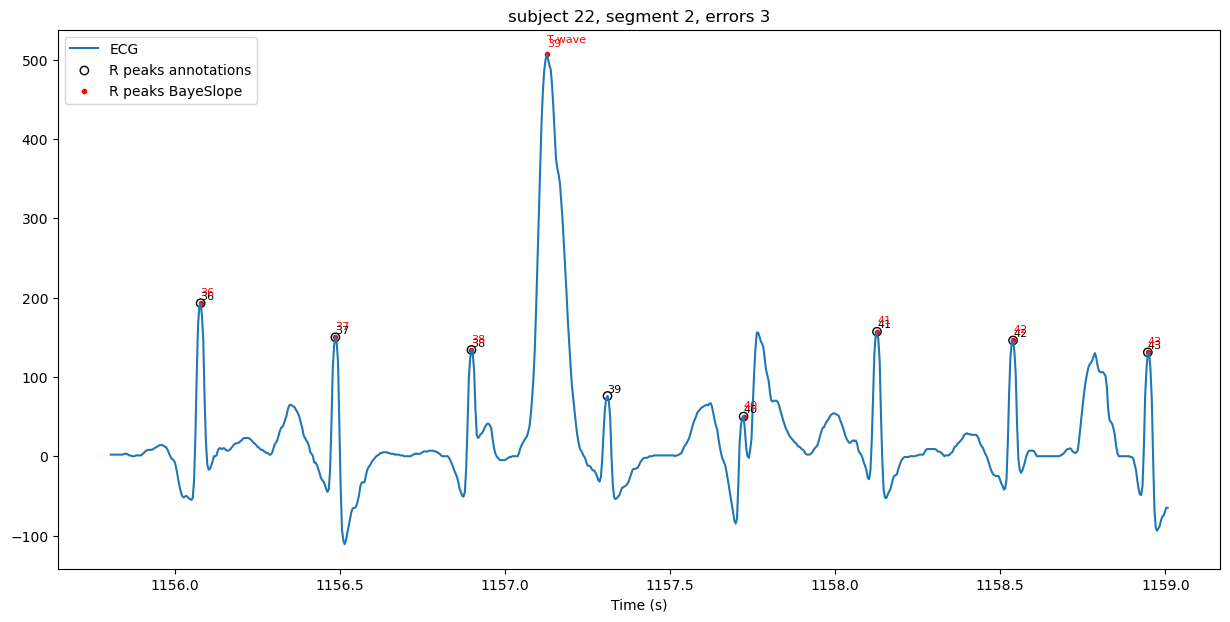

In [11]:
for r in Errors.itertuples():
    '''
    if r.subject==15 or (r.subject, r.segment)==(13, 4):
        print(f'subject {r.subject}, segment {r.segment}, errors {r.error_id}')
        print('No errors really')
    else:
        plot_segment_part_class(r.subject, r.segment, r.error_id, r.start, r.end)
    '''
    plot_segment_part_class(r.subject, r.segment, r.error_id, r.start, r.end)